In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna
from optuna.distributions import UniformDistribution, LogUniformDistribution, IntUniformDistribution, CategoricalDistribution
import sys
sys.path.append("../.")
from geothermal_prediction.utils import save_to_csv
from geothermal_prediction.ml_well_optuna import MLFramework


# Load data
data = pd.read_csv('../data/processed/log_data_ml.csv')

# Scenario Parameters
TARGET_COLUMNS = ['Th_Cond', 'Th_Diff']
FEATURE_COLUMNS = [
    'Gamma_Ray_interpolated', 
    'Bulk_Density_interpolated', 
    'Porosity_interpolated',
    'Sonic_Log_interpolated'
]
GROUP_COLUMN = 'Well_ID'
DEPTH_COLUMN = 'Depth'

# Modeling Parameters
METRIC = 'MAE'
NUM_SPLITS = len(data['Well_ID'].unique())  # Number of cross-validation splits
N_TRIALS = 300    # Number of Optuna trials per model-target combination

# Random State for Reproducibility
RANDOM_STATE = 42


# Initialize the framework
framework = MLFramework(
    data=data, 
    target_columns=TARGET_COLUMNS, 
    group_column=GROUP_COLUMN, 
    feature_columns=FEATURE_COLUMNS,
    depth_column=DEPTH_COLUMN,
    metric=METRIC
)

# Define models and their hyperparameter grids

# Ridge Regressor Hyperparameter Search Space
param_grid_ridge = {
    'alpha': LogUniformDistribution(low=1e-4, high=100.0)
}

# Random Forest Regressor Hyperparameter Search Space
param_grid_rf = {
    'n_estimators': IntUniformDistribution(low=100, high=2000),
    'max_depth': IntUniformDistribution(low=5, high=100),
    'min_samples_split': IntUniformDistribution(low=2, high=50),
    'min_samples_leaf': IntUniformDistribution(low=1, high=50),
    'max_features': CategoricalDistribution(choices=['sqrt', 'log2', None])  
}

# LightGBM Regressor Hyperparameter Search Space
param_grid_lgbm = {
    'num_leaves': IntUniformDistribution(low=20, high=200),
    'max_depth': IntUniformDistribution(low=3, high=20), 
    'learning_rate': LogUniformDistribution(low=1e-4, high=0.5),
    'n_estimators': IntUniformDistribution(low=100, high=1500),
    'min_child_samples': IntUniformDistribution(low=5, high=200),
    'subsample': UniformDistribution(low=0.5, high=1.0),
    'boosting_type': CategoricalDistribution(choices=['gbdt', 'dart', 'goss']), 
    'objective': CategoricalDistribution(choices=['regression', 'huber', 'fair']) 
}

# XGBoost Regressor Hyperparameter Search Space
param_grid_xgb = {
    'learning_rate': LogUniformDistribution(low=1e-4, high=0.5),
    'max_depth': IntUniformDistribution(low=3, high=20),
    'n_estimators': IntUniformDistribution(low=100, high=2000),
    'subsample': UniformDistribution(low=0.5, high=1.0),
    'colsample_bytree': UniformDistribution(low=0.5, high=1.0),
    'gamma': UniformDistribution(low=1e-4, high=10),
    'reg_alpha': LogUniformDistribution(low=1e-4, high=10.0),
    'reg_lambda': LogUniformDistribution(low=1e-4, high=10.0),
    'min_child_weight': IntUniformDistribution(low=1, high=50),
    'objective': CategoricalDistribution(choices=['reg:squarederror', 'reg:pseudohubererror'])
}

models_with_params = {
    'Ridge': (
        Ridge(random_state=RANDOM_STATE),
        param_grid_ridge
    ),
    'RandomForestRegressor': (
        RandomForestRegressor(random_state=RANDOM_STATE),
        param_grid_rf
    ),
    'LGBMRegressor': (
        LGBMRegressor(random_state=RANDOM_STATE),
        param_grid_lgbm
    ),
    'XGBRegressor': (
        XGBRegressor(random_state=RANDOM_STATE),
        param_grid_xgb
    )
}

# Evaluate models with custom nested CV and get final models
combined_results, final_models = framework.evaluate_models_with_optuna(
    models_with_params=models_with_params,
    num_splits=NUM_SPLITS,
    n_trials=N_TRIALS
)

# Display combined results
combined_results_df = pd.DataFrame(combined_results).T
save_to_csv(combined_results_df, 'optuna_paramgrid', folder='data/results/')

# Collect predictions
results_df = framework.collect_predictions(
    combined_results=combined_results,
    models_with_params=models_with_params,
    num_splits=NUM_SPLITS
)
save_to_csv(results_df, 'optuna_results', folder='data/results/')

[I 2024-12-11 18:49:00,291] A new study created in memory with name: no-name-c3139115-b162-4266-a5c2-ed3a1b6bc8ac



Evaluating Model: Ridge

Optimizing hyperparameters for target: Th_Cond


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-12-11 18:49:00,350] Trial 0 finished with value: 0.4793338105481861 and parameters: {'alpha': 0.0001435520443774824}. Best is trial 0 with value: 0.4793338105481861.
[I 2024-12-11 18:49:00,381] Trial 1 finished with value: 0.47933502939369066 and parameters: {'alpha': 0.015279275247270022}. Best is trial 0 with value: 0.4793338105481861.
[I 2024-12-11 18:49:00,416] Trial 2 finished with value: 0.4793338882100776 and parameters: {'alpha': 0.0011080059557130556}. Best is trial 0 with value: 0.4793338105481861.
[I 2024-12-11 18:49:00,479] Trial 3 finished with value: 0.47933899716227973 and parameters: {'alpha': 0.06378223949750794}. Best is trial 0 with value: 0.4793338105481861.
[I 2024-12-11 18:49:00,514] Trial 4 finished with value: 0.4793425910238301 and parameters: {'alpha': 0.1076521768240762}. Best is trial 0 with value: 0.4793338105481861.
[I 2024-12-11 18:49:00,545] Trial 5 finished with value: 0.4814291832291999 and parameters: {'alpha': 21.56197618693836}. Best is tria

[I 2024-12-11 18:49:09,235] A new study created in memory with name: no-name-a3b5e27d-f236-4e3a-9a4f-e1f8aeaf2187


[I 2024-12-11 18:49:09,102] Trial 294 finished with value: 0.4793338144180239 and parameters: {'alpha': 0.0001916102446904136}. Best is trial 201 with value: 0.4793338070420538.
[I 2024-12-11 18:49:09,131] Trial 295 finished with value: 0.4793338092410822 and parameters: {'alpha': 0.00012731956122617632}. Best is trial 201 with value: 0.4793338070420538.
[I 2024-12-11 18:49:09,156] Trial 296 finished with value: 0.47933381189194035 and parameters: {'alpha': 0.00016023967290687953}. Best is trial 201 with value: 0.4793338070420538.
[I 2024-12-11 18:49:09,183] Trial 297 finished with value: 0.4793338071056554 and parameters: {'alpha': 0.00010080041311637811}. Best is trial 201 with value: 0.4793338070420538.
[I 2024-12-11 18:49:09,208] Trial 298 finished with value: 0.479333807063257 and parameters: {'alpha': 0.00010027388256403217}. Best is trial 201 with value: 0.4793338070420538.
[I 2024-12-11 18:49:09,232] Trial 299 finished with value: 0.47933380969079764 and parameters: {'alpha': 0

  0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-12-11 18:49:09,276] Trial 0 finished with value: 0.5568290578100612 and parameters: {'alpha': 0.011991571476891165}. Best is trial 0 with value: 0.5568290578100612.
[I 2024-12-11 18:49:09,306] Trial 1 finished with value: 0.5566776849277857 and parameters: {'alpha': 9.600424911189723}. Best is trial 1 with value: 0.5566776849277857.
[I 2024-12-11 18:49:09,378] Trial 2 finished with value: 0.5568293478849075 and parameters: {'alpha': 0.00026129504189917796}. Best is trial 1 with value: 0.5566776849277857.
[I 2024-12-11 18:49:09,410] Trial 3 finished with value: 0.5568293075179689 and parameters: {'alpha': 0.0018935122621319793}. Best is trial 1 with value: 0.5566776849277857.
[I 2024-12-11 18:49:09,439] Trial 4 finished with value: 0.55682723314797 and parameters: {'alpha': 0.08584510538117843}. Best is trial 1 with value: 0.5566776849277857.
[I 2024-12-11 18:49:09,460] Trial 5 finished with value: 0.5568292995332926 and parameters: {'alpha': 0.0022163753223628144}. Best is tria

[I 2024-12-11 18:49:17,573] A new study created in memory with name: no-name-50ec8c5a-7fde-436c-9c07-d5090b562de2


[I 2024-12-11 18:49:17,471] Trial 296 finished with value: 0.5565926904965185 and parameters: {'alpha': 33.09419550201722}. Best is trial 150 with value: 0.5565906941267209.
[I 2024-12-11 18:49:17,498] Trial 297 finished with value: 0.5566239740547033 and parameters: {'alpha': 40.88463139148918}. Best is trial 150 with value: 0.5565906941267209.
[I 2024-12-11 18:49:17,527] Trial 298 finished with value: 0.556636567870853 and parameters: {'alpha': 15.791135100338009}. Best is trial 150 with value: 0.5565906941267209.
[I 2024-12-11 18:49:17,555] Trial 299 finished with value: 0.5565982444713093 and parameters: {'alpha': 25.268003889533727}. Best is trial 150 with value: 0.5565906941267209.
Best Params for Ridge - Th_Diff: {'alpha': 31.340320729848877} with MAE: 0.5566
Final model trained for target 'Th_Cond' with Ridge.
Final model trained for target 'Th_Diff' with Ridge.

Evaluating Model: RandomForestRegressor

Optimizing hyperparameters for target: Th_Cond


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-12-11 18:49:22,821] Trial 0 finished with value: 0.5783730890781394 and parameters: {'n_estimators': 1124, 'max_depth': 95, 'min_samples_split': 38, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5783730890781394.
[I 2024-12-11 18:49:33,312] Trial 1 finished with value: 0.5743929258613262 and parameters: {'n_estimators': 1892, 'max_depth': 16, 'min_samples_split': 32, 'min_samples_leaf': 28, 'max_features': None}. Best is trial 1 with value: 0.5743929258613262.
[I 2024-12-11 18:49:34,807] Trial 2 finished with value: 0.5817528415093755 and parameters: {'n_estimators': 282, 'max_depth': 94, 'min_samples_split': 25, 'min_samples_leaf': 38, 'max_features': None}. Best is trial 1 with value: 0.5743929258613262.
[I 2024-12-11 18:49:39,343] Trial 3 finished with value: 0.5706232456174273 and parameters: {'n_estimators': 947, 'max_depth': 10, 'min_samples_split': 31, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.57062324

[I 2024-12-11 19:16:04,153] A new study created in memory with name: no-name-d8d97793-61cc-4c79-b15b-212b5adda414


[I 2024-12-11 19:16:04,150] Trial 299 finished with value: 0.5463078077290909 and parameters: {'n_estimators': 318, 'max_depth': 48, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 276 with value: 0.5434047026171904.
Best Params for RandomForestRegressor - Th_Cond: {'n_estimators': 365, 'max_depth': 48, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': None} with MAE: 0.5434

Optimizing hyperparameters for target: Th_Diff


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-12-11 19:16:05,519] Trial 0 finished with value: 0.47836888574366454 and parameters: {'n_estimators': 284, 'max_depth': 37, 'min_samples_split': 36, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.47836888574366454.
[I 2024-12-11 19:16:06,707] Trial 1 finished with value: 0.45085942936038004 and parameters: {'n_estimators': 217, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.45085942936038004.
[I 2024-12-11 19:16:15,489] Trial 2 finished with value: 0.4822911553653254 and parameters: {'n_estimators': 1692, 'max_depth': 71, 'min_samples_split': 24, 'min_samples_leaf': 36, 'max_features': None}. Best is trial 1 with value: 0.45085942936038004.
[I 2024-12-11 19:16:20,160] Trial 3 finished with value: 0.4771322507018503 and parameters: {'n_estimators': 1060, 'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 1 with value: 0.45

[I 2024-12-11 19:49:28,099] A new study created in memory with name: no-name-040fd048-b3bf-4863-9b18-62b1a6ae9824


Final model trained for target 'Th_Diff' with RandomForestRegressor.

Evaluating Model: LGBMRegressor

Optimizing hyperparameters for target: Th_Cond


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-12-11 19:49:28,409] Trial 0 finished with value: 0.6292996031604767 and parameters: {'num_leaves': 36, 'max_depth': 8, 'learning_rate': 0.12788390651014583, 'n_estimators': 954, 'min_child_samples': 186, 'subsample': 0.5283497496850431, 'boosting_type': 'goss', 'objective': 'fair'}. Best is trial 0 with value: 0.6292996031604767.
[I 2024-12-11 19:49:29,547] Trial 1 finished with value: 0.6835508425786495 and parameters: {'num_leaves': 178, 'max_depth': 10, 'learning_rate': 0.0004329635748666249, 'n_estimators': 827, 'min_child_samples': 36, 'subsample': 0.837038775604128, 'boosting_type': 'goss', 'objective': 'fair'}. Best is trial 0 with value: 0.6292996031604767.
[I 2024-12-11 19:49:29,710] Trial 2 finished with value: 0.7932846564081643 and parameters: {'num_leaves': 47, 'max_depth': 8, 'learning_rate': 0.00041959622047210883, 'n_estimators': 257, 'min_child_samples': 145, 'subsample': 0.994727284844126, 'boosting_type': 'goss', 'objective': 'huber'}. Best is trial 0 with va

[I 2024-12-11 20:18:45,832] A new study created in memory with name: no-name-704a0319-b3ec-4311-91f9-733e2d8cc8e5


[I 2024-12-11 20:18:45,828] Trial 299 finished with value: 0.5294580938778033 and parameters: {'num_leaves': 136, 'max_depth': 4, 'learning_rate': 0.0455670732680357, 'n_estimators': 1399, 'min_child_samples': 18, 'subsample': 0.6481988380077162, 'boosting_type': 'dart', 'objective': 'fair'}. Best is trial 201 with value: 0.5069711052689041.
Best Params for LGBMRegressor - Th_Cond: {'num_leaves': 197, 'max_depth': 5, 'learning_rate': 0.027935426586745266, 'n_estimators': 1298, 'min_child_samples': 11, 'subsample': 0.8457939680648948, 'boosting_type': 'dart', 'objective': 'fair'} with MAE: 0.5070

Optimizing hyperparameters for target: Th_Diff


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-12-11 20:18:47,017] Trial 0 finished with value: 1.355710043500535 and parameters: {'num_leaves': 55, 'max_depth': 3, 'learning_rate': 0.00031349866469809783, 'n_estimators': 415, 'min_child_samples': 169, 'subsample': 0.9861245613716598, 'boosting_type': 'dart', 'objective': 'huber'}. Best is trial 0 with value: 1.355710043500535.
[I 2024-12-11 20:18:47,549] Trial 1 finished with value: 0.5326194852875811 and parameters: {'num_leaves': 67, 'max_depth': 7, 'learning_rate': 0.14613528229401782, 'n_estimators': 1078, 'min_child_samples': 102, 'subsample': 0.7197911538837374, 'boosting_type': 'goss', 'objective': 'regression'}. Best is trial 1 with value: 0.5326194852875811.
[I 2024-12-11 20:18:50,769] Trial 2 finished with value: 0.505466074108709 and parameters: {'num_leaves': 95, 'max_depth': 5, 'learning_rate': 0.3120262362988355, 'n_estimators': 956, 'min_child_samples': 144, 'subsample': 0.8955799887484592, 'boosting_type': 'dart', 'objective': 'huber'}. Best is trial 2 with

[I 2024-12-11 20:35:06,998] A new study created in memory with name: no-name-7bbaffbe-eb70-49f8-bc0a-74c249bca617


Final model trained for target 'Th_Diff' with LGBMRegressor.

Evaluating Model: XGBRegressor

Optimizing hyperparameters for target: Th_Cond


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-12-11 20:35:12,629] Trial 0 finished with value: 0.6052585721224882 and parameters: {'learning_rate': 0.05225751161832936, 'max_depth': 13, 'n_estimators': 1573, 'subsample': 0.981249504196755, 'colsample_bytree': 0.8141559641523661, 'gamma': 4.684608498609523, 'reg_alpha': 0.00013869013152800603, 'reg_lambda': 0.543288224251179, 'min_child_weight': 18, 'objective': 'reg:squarederror'}. Best is trial 0 with value: 0.6052585721224882.
[I 2024-12-11 20:35:17,129] Trial 1 finished with value: 0.6263095306466646 and parameters: {'learning_rate': 0.002239793042794253, 'max_depth': 20, 'n_estimators': 1634, 'subsample': 0.8700388504706829, 'colsample_bytree': 0.5974210556967776, 'gamma': 6.136051502863543, 'reg_alpha': 0.0005784395670646526, 'reg_lambda': 0.0008792799027949654, 'min_child_weight': 26, 'objective': 'reg:squarederror'}. Best is trial 0 with value: 0.6052585721224882.
[I 2024-12-11 20:35:21,487] Trial 2 finished with value: 0.6900946158220626 and parameters: {'learning_

[I 2024-12-11 20:52:38,983] A new study created in memory with name: no-name-13e1df7c-2d68-46b7-b53d-1574f37878ab


[I 2024-12-11 20:52:38,979] Trial 299 finished with value: 0.46777226020002255 and parameters: {'learning_rate': 0.0034180687270006045, 'max_depth': 10, 'n_estimators': 611, 'subsample': 0.5525628953084869, 'colsample_bytree': 0.9793205441100877, 'gamma': 0.003981665375307641, 'reg_alpha': 4.32622168027489, 'reg_lambda': 0.000505718981935624, 'min_child_weight': 2, 'objective': 'reg:pseudohubererror'}. Best is trial 294 with value: 0.45775381095998846.
Best Params for XGBRegressor - Th_Cond: {'learning_rate': 0.004398310727639693, 'max_depth': 10, 'n_estimators': 1059, 'subsample': 0.5387747695473197, 'colsample_bytree': 0.9766572940790496, 'gamma': 0.00044698111728022627, 'reg_alpha': 5.101210754986487, 'reg_lambda': 0.0005677422977154234, 'min_child_weight': 1, 'objective': 'reg:pseudohubererror'} with MAE: 0.4578

Optimizing hyperparameters for target: Th_Diff


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-12-11 20:52:40,421] Trial 0 finished with value: 0.4401357750202073 and parameters: {'learning_rate': 0.17775815030397174, 'max_depth': 13, 'n_estimators': 642, 'subsample': 0.5752711639829882, 'colsample_bytree': 0.6811949298081473, 'gamma': 0.19023587499793906, 'reg_alpha': 0.43985304456609975, 'reg_lambda': 0.3088321664771248, 'min_child_weight': 39, 'objective': 'reg:pseudohubererror'}. Best is trial 0 with value: 0.4401357750202073.
[I 2024-12-11 20:52:43,313] Trial 1 finished with value: 0.5387763614836764 and parameters: {'learning_rate': 0.0004052718277536213, 'max_depth': 11, 'n_estimators': 1444, 'subsample': 0.6830756535804066, 'colsample_bytree': 0.7529115330446452, 'gamma': 0.9103576224915777, 'reg_alpha': 0.08044230443291951, 'reg_lambda': 0.07309694800050737, 'min_child_weight': 24, 'objective': 'reg:pseudohubererror'}. Best is trial 0 with value: 0.4401357750202073.
[I 2024-12-11 20:52:44,109] Trial 2 finished with value: 0.6793239324212985 and parameters: {'lea

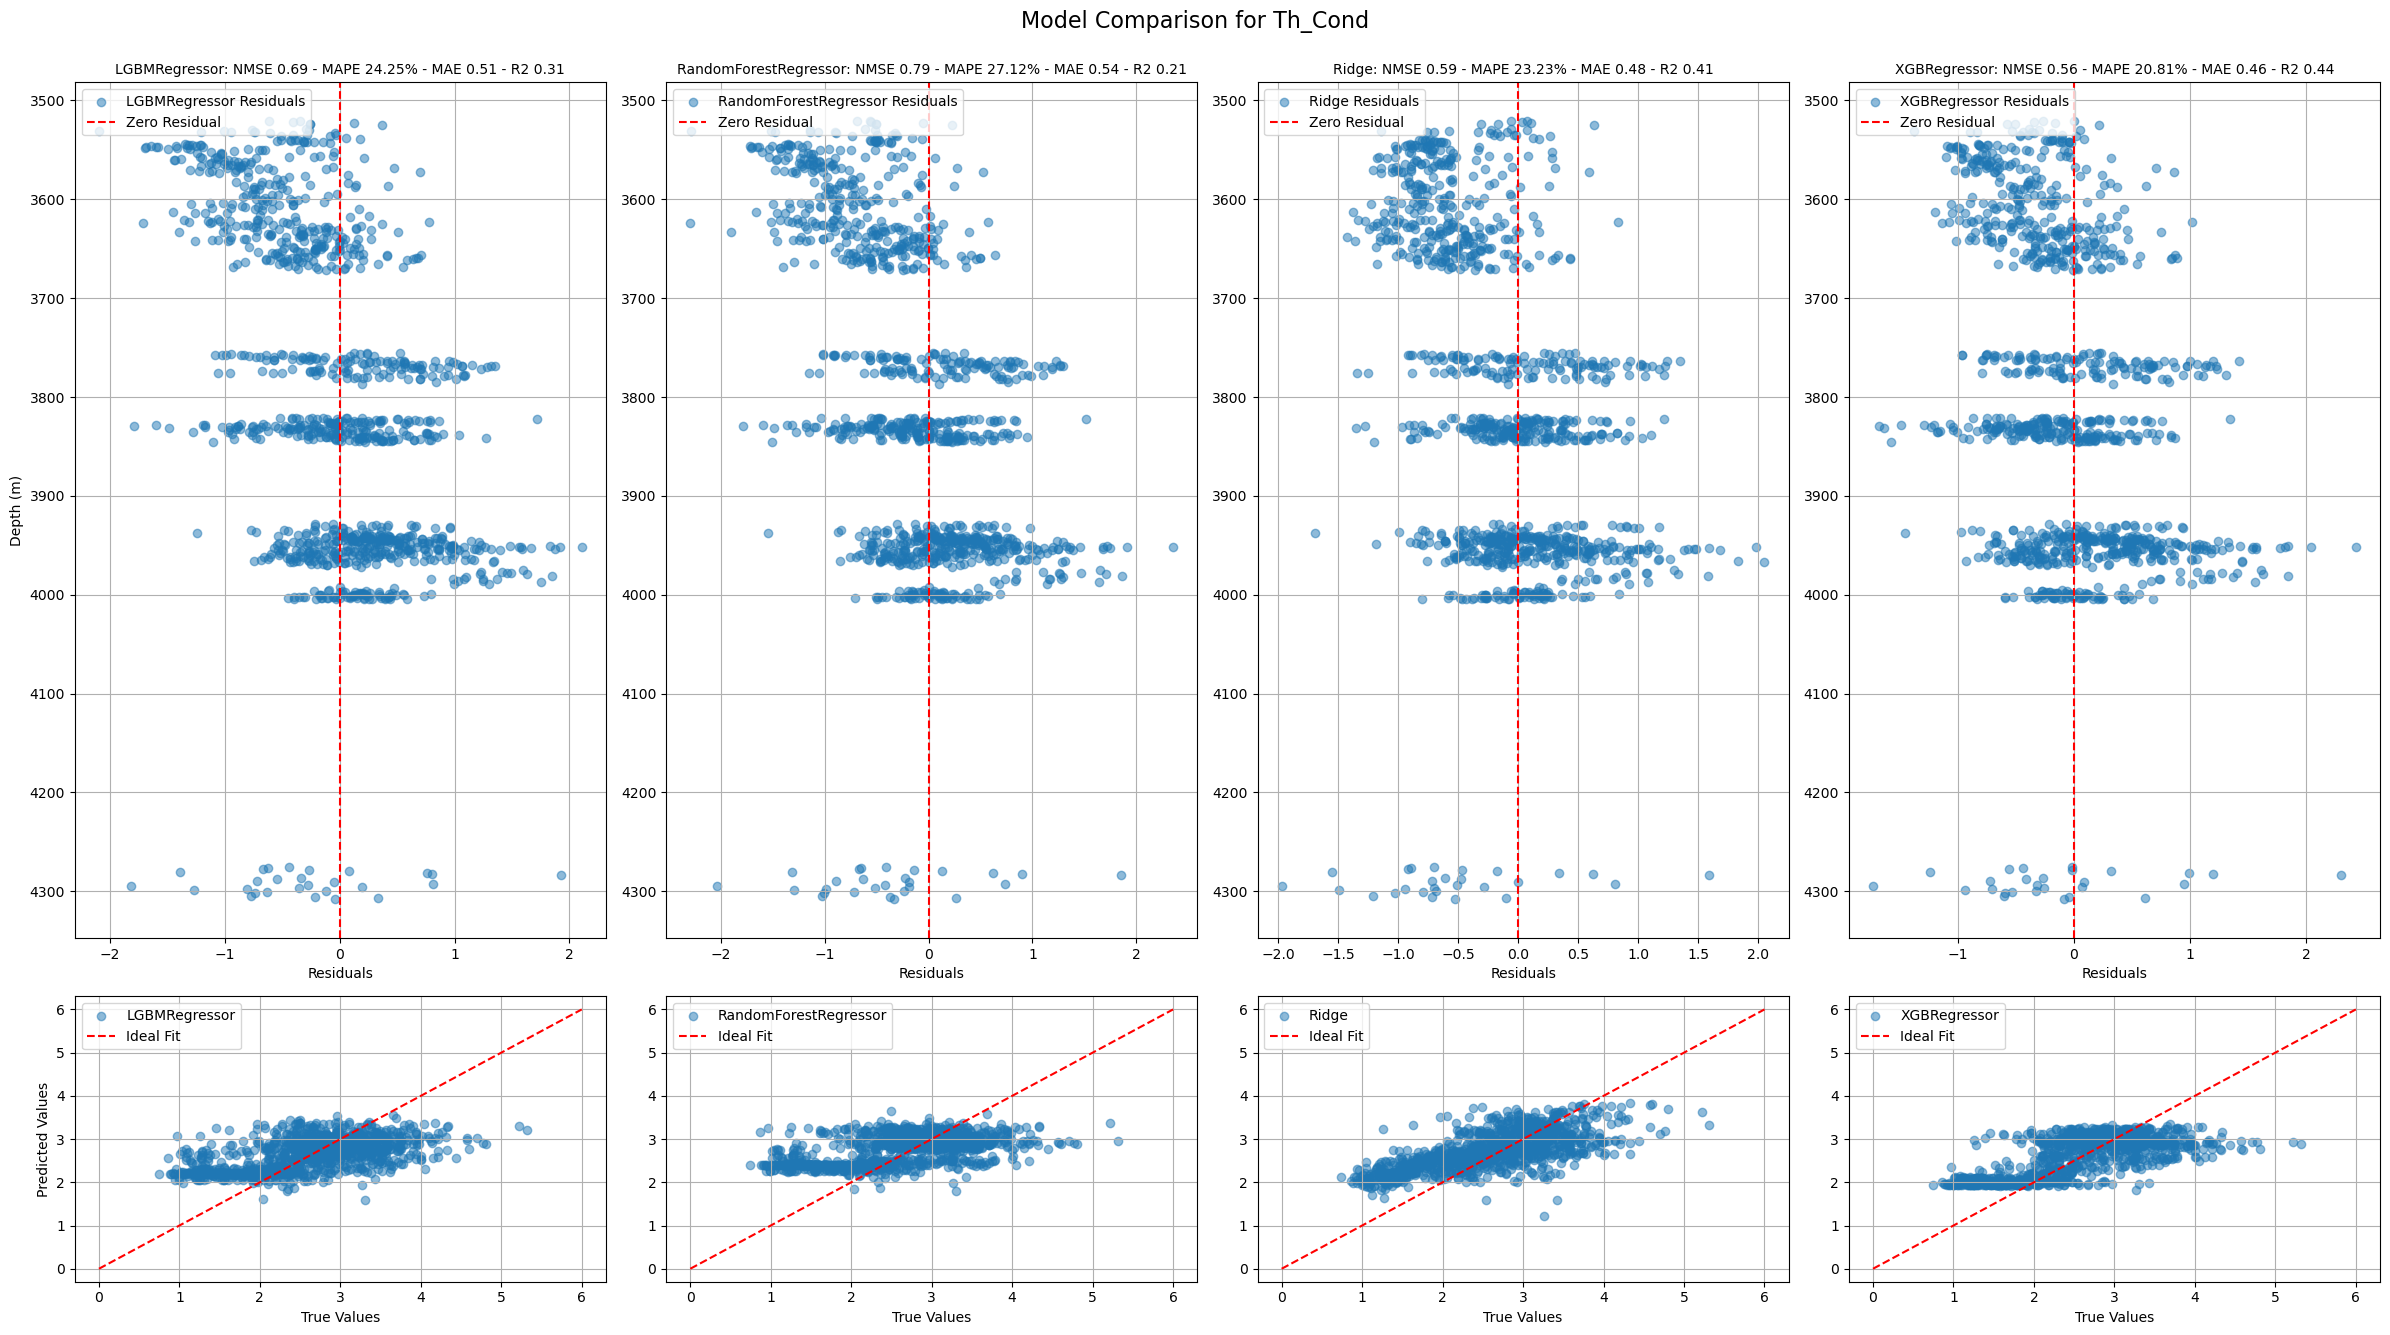

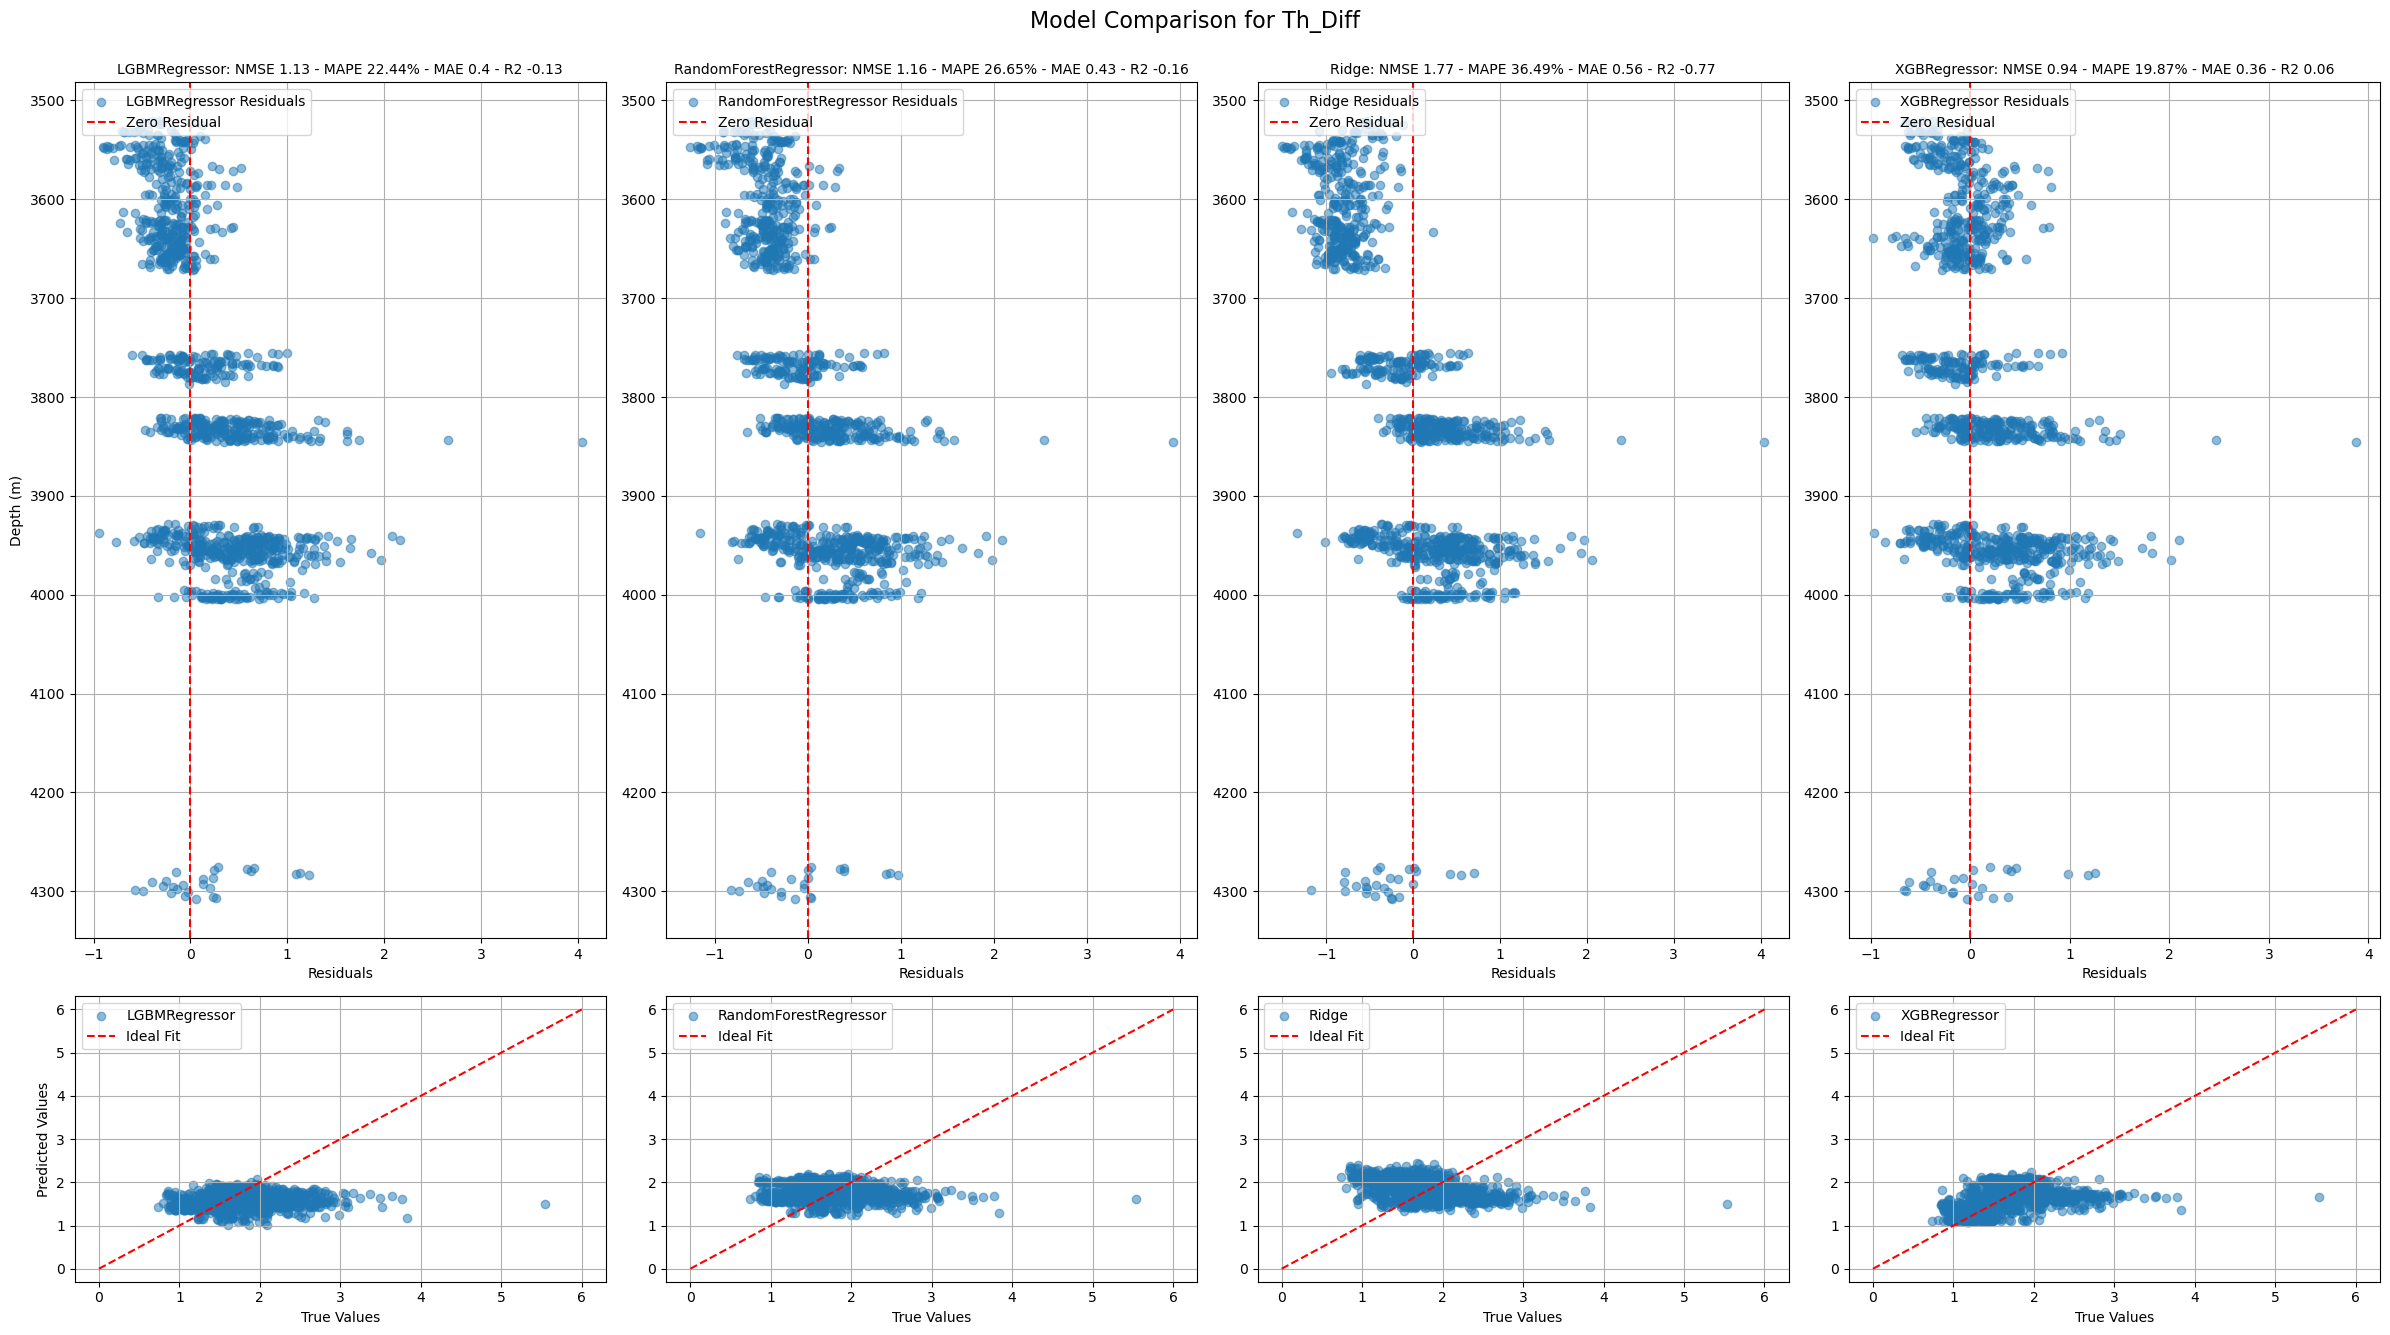

In [2]:
# Plot Model Comparison
framework.plot_model_comparison(results_df)

Well: E18-05


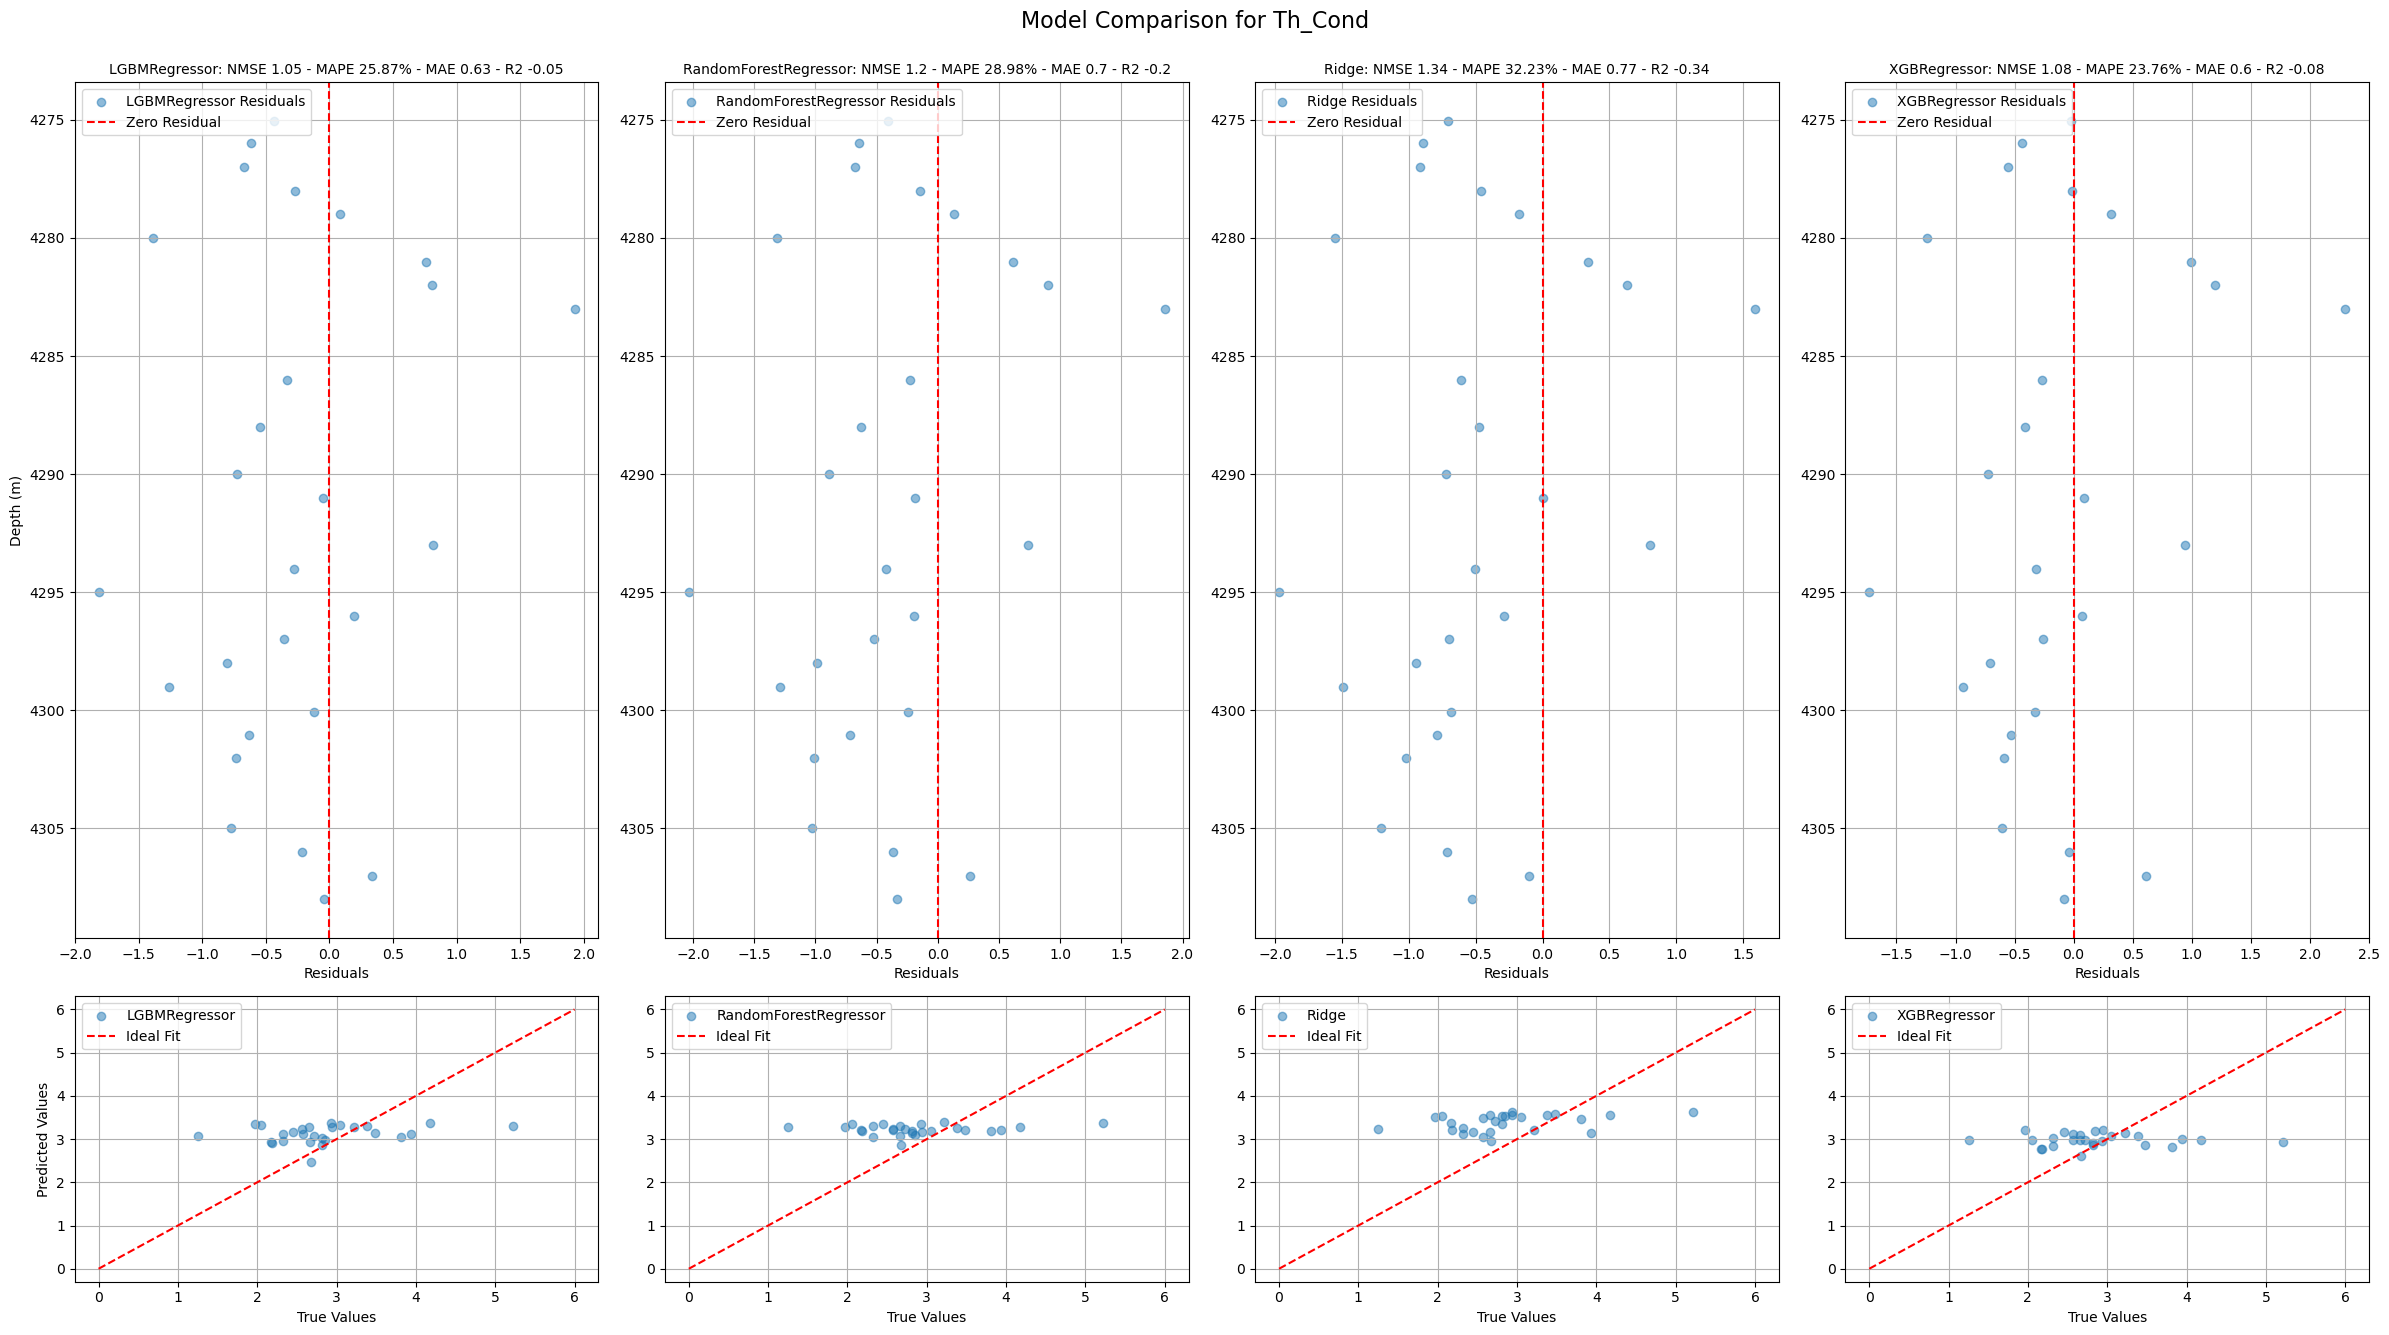

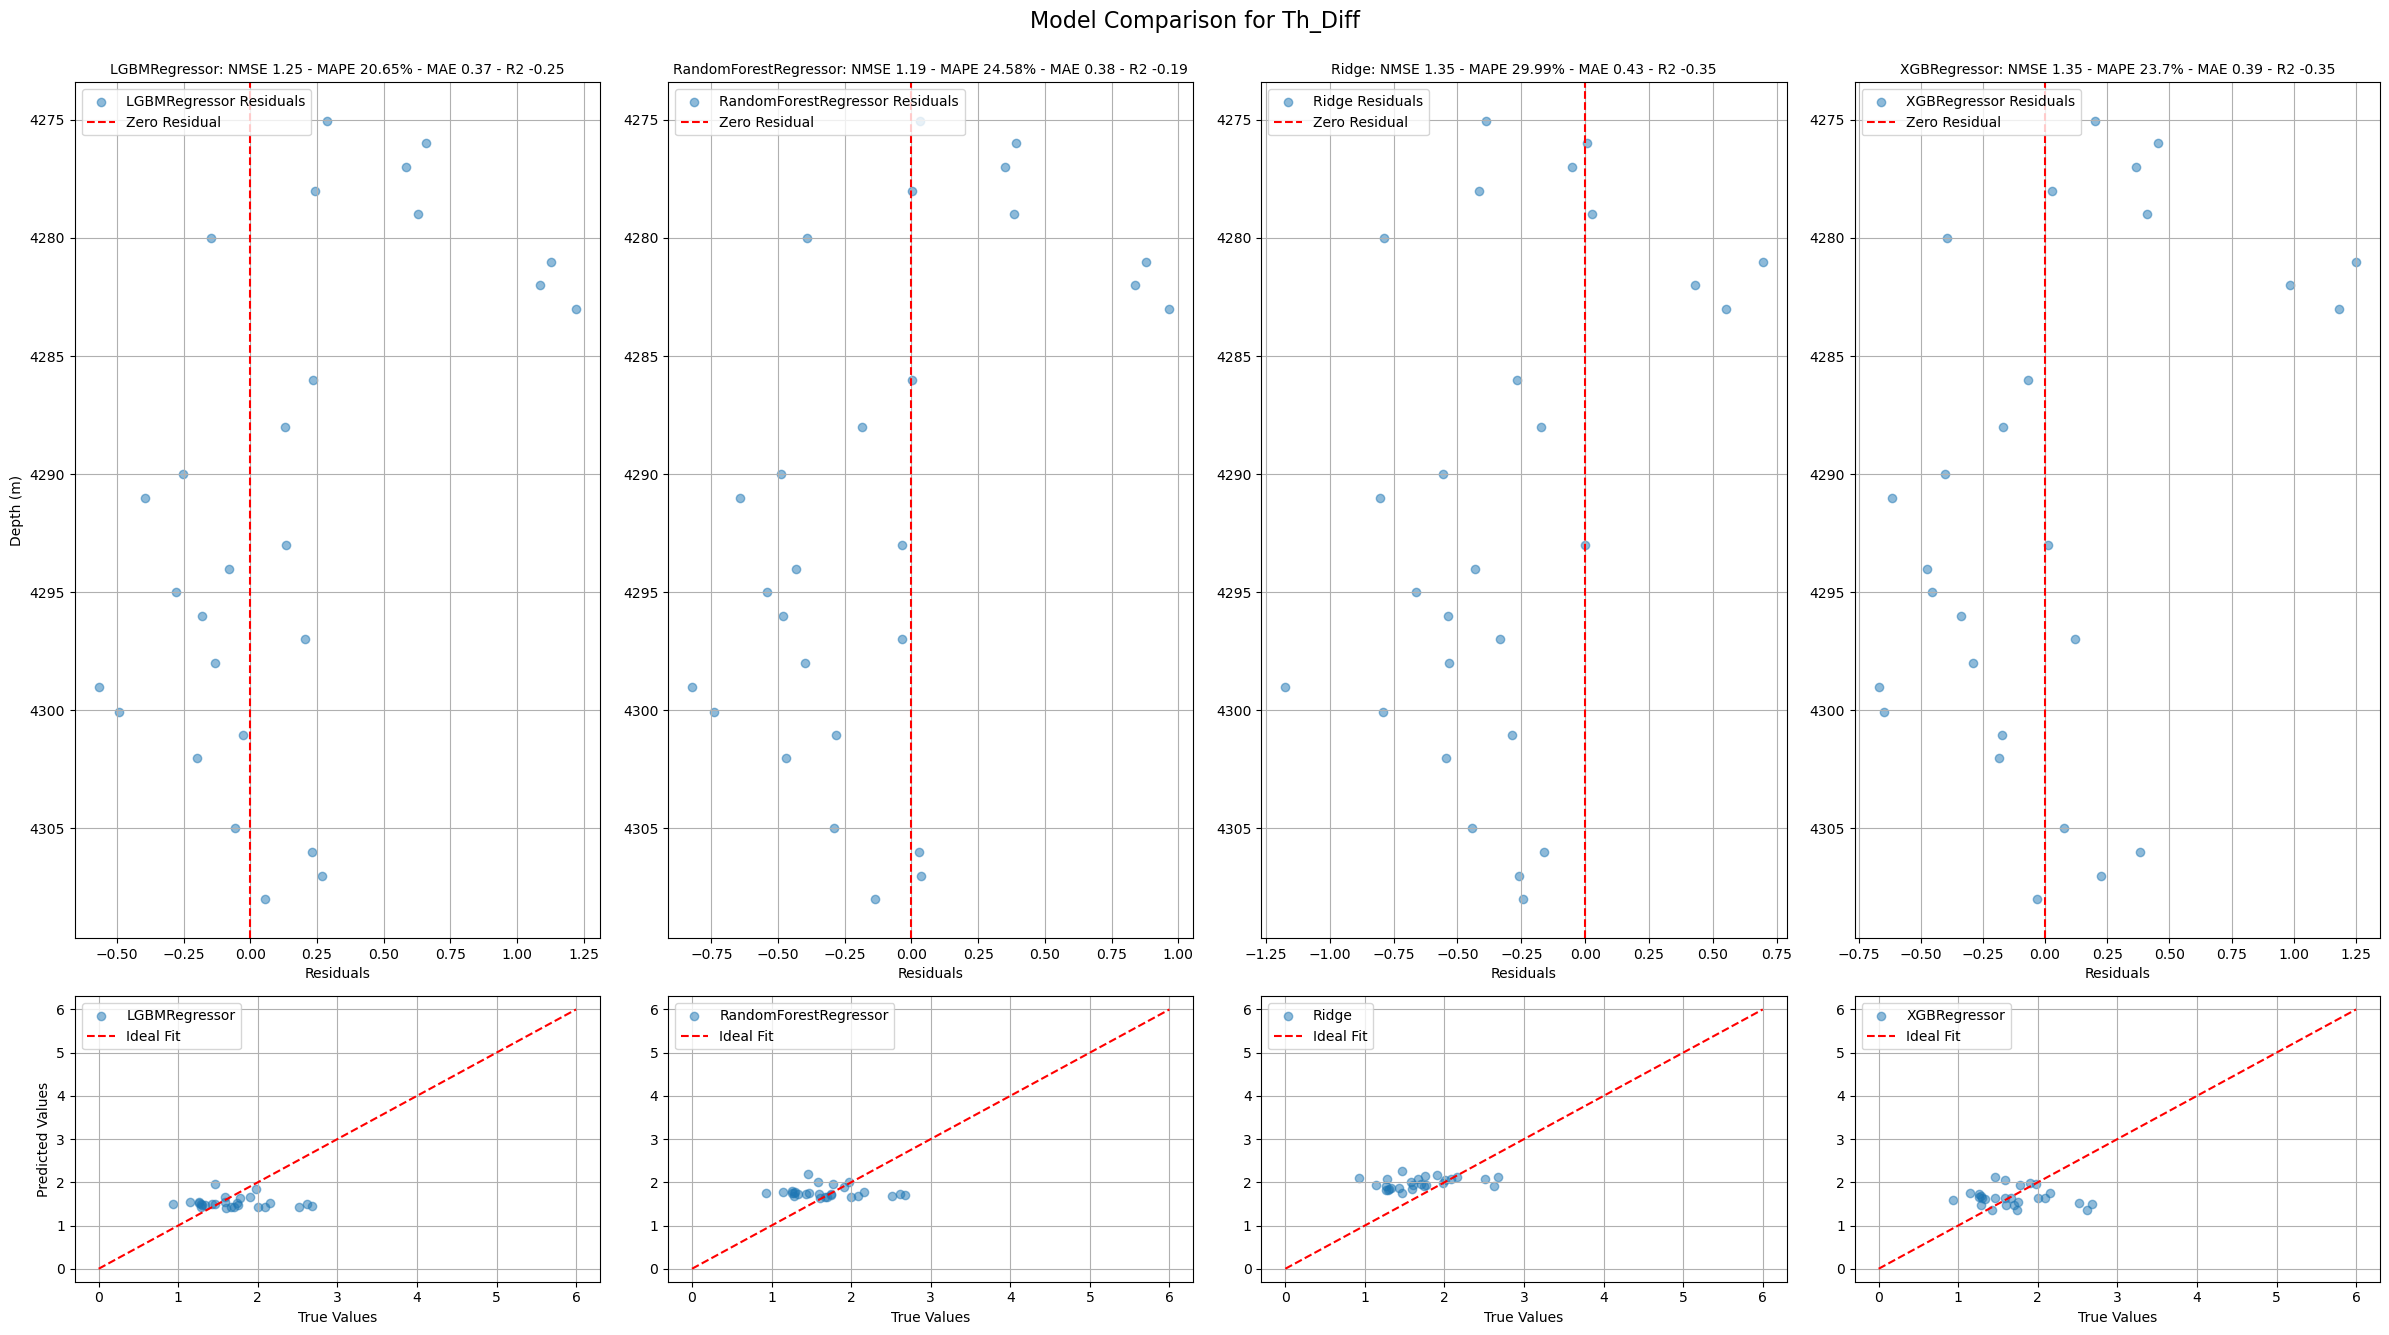

Well: K18-07x


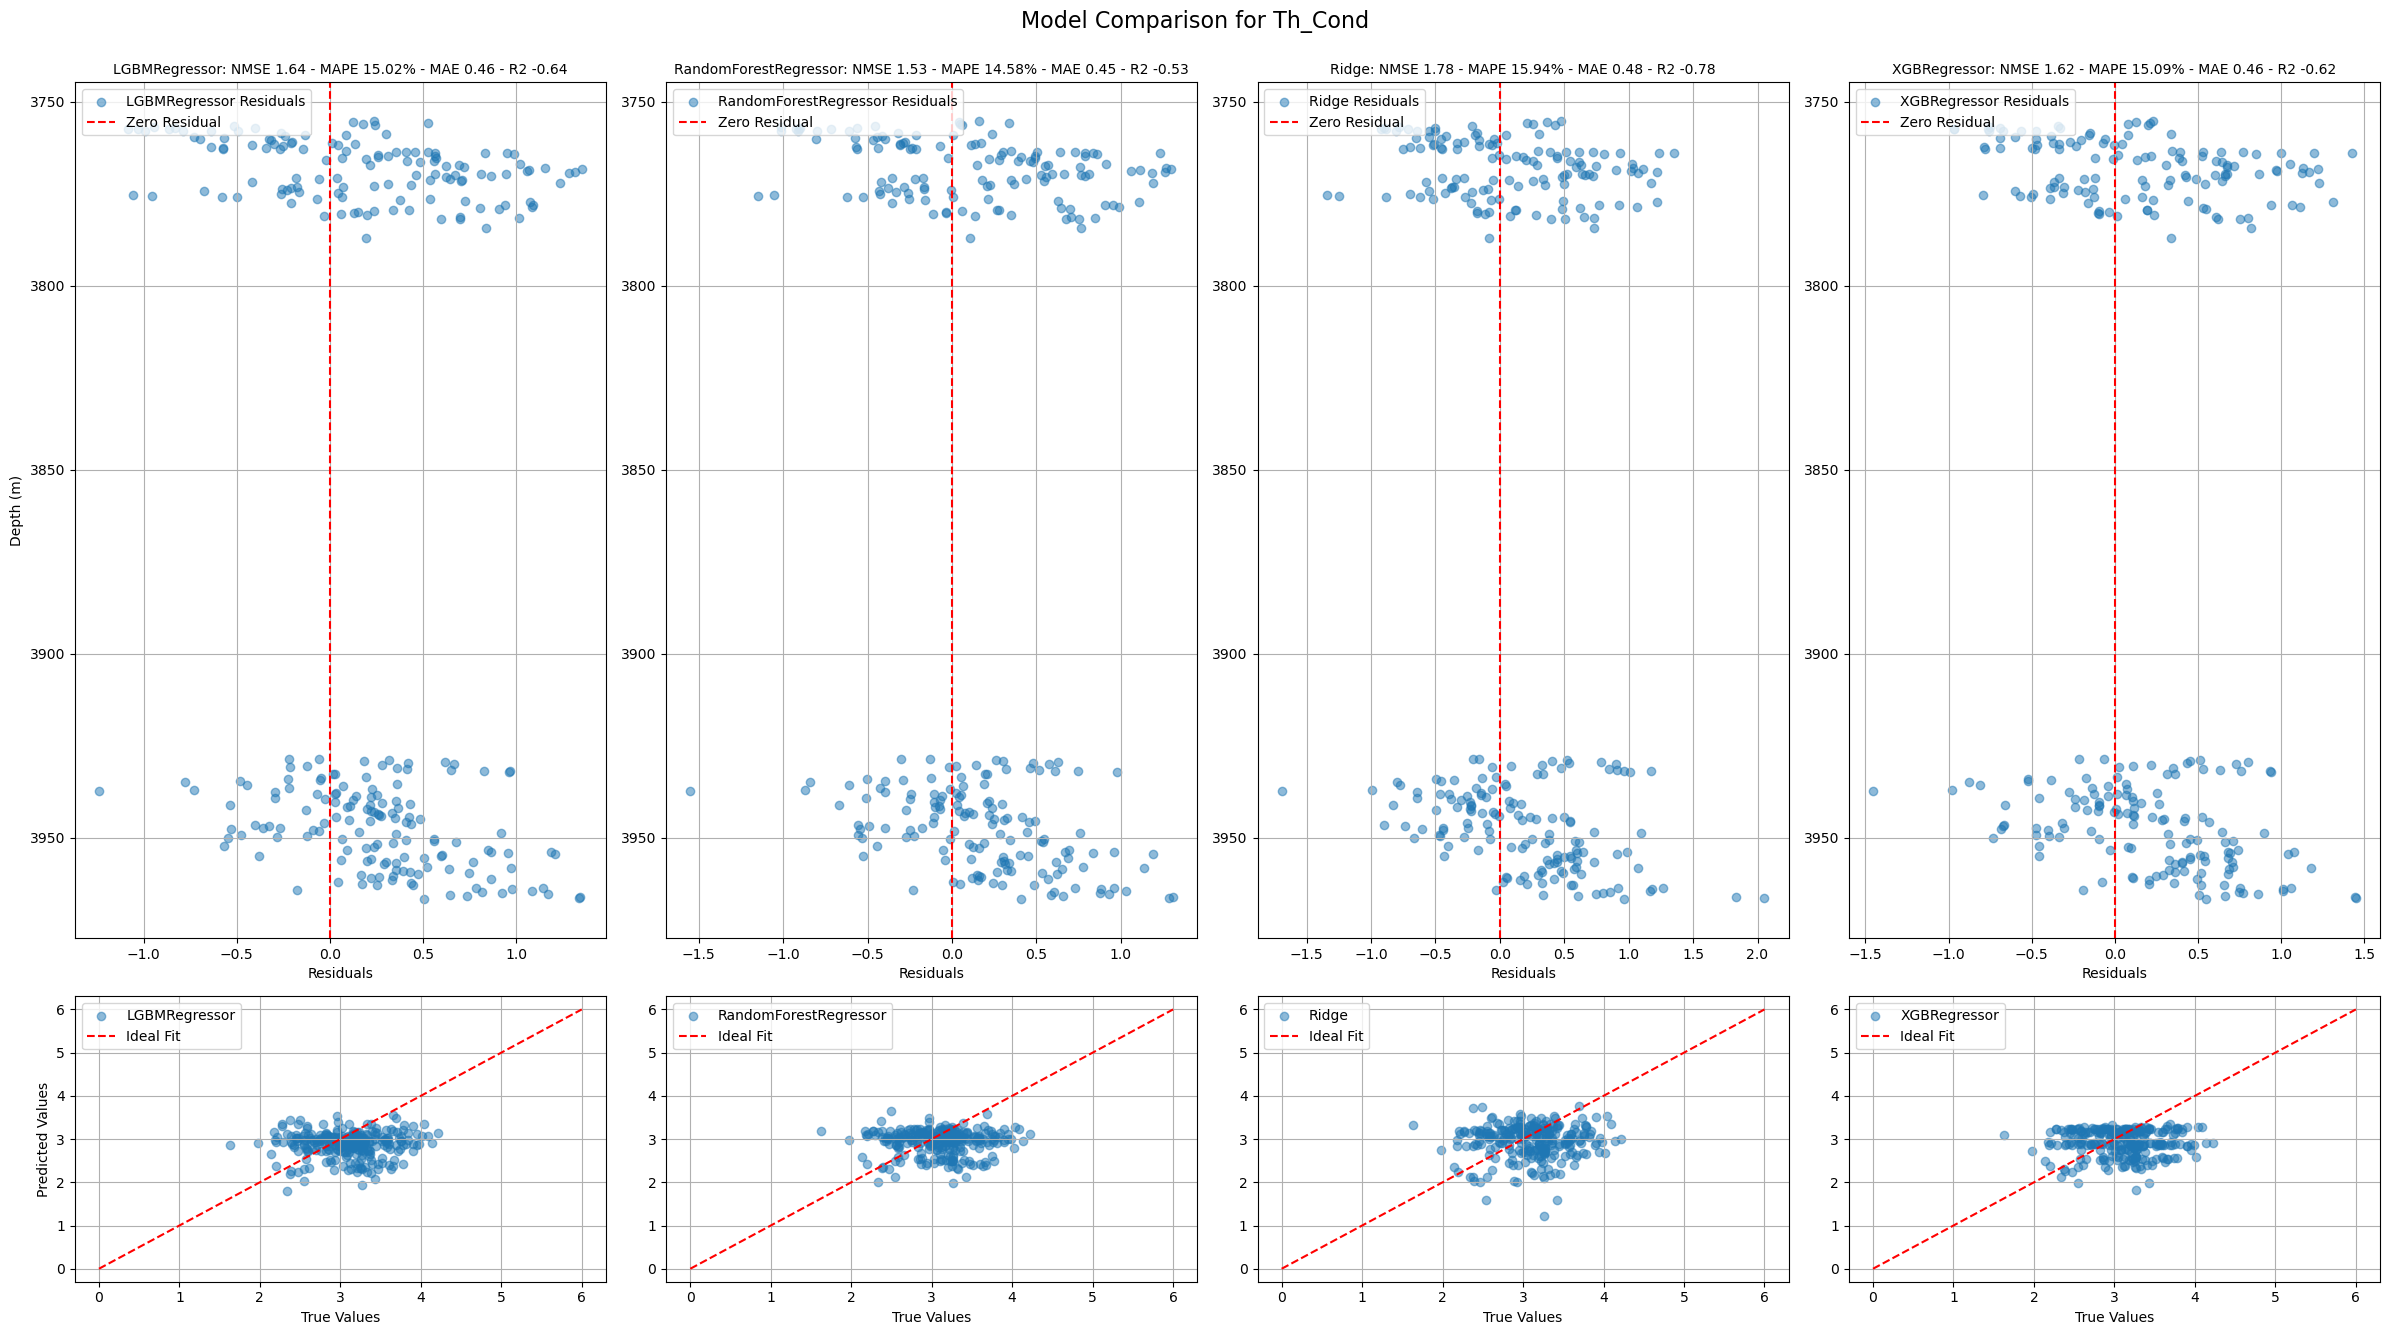

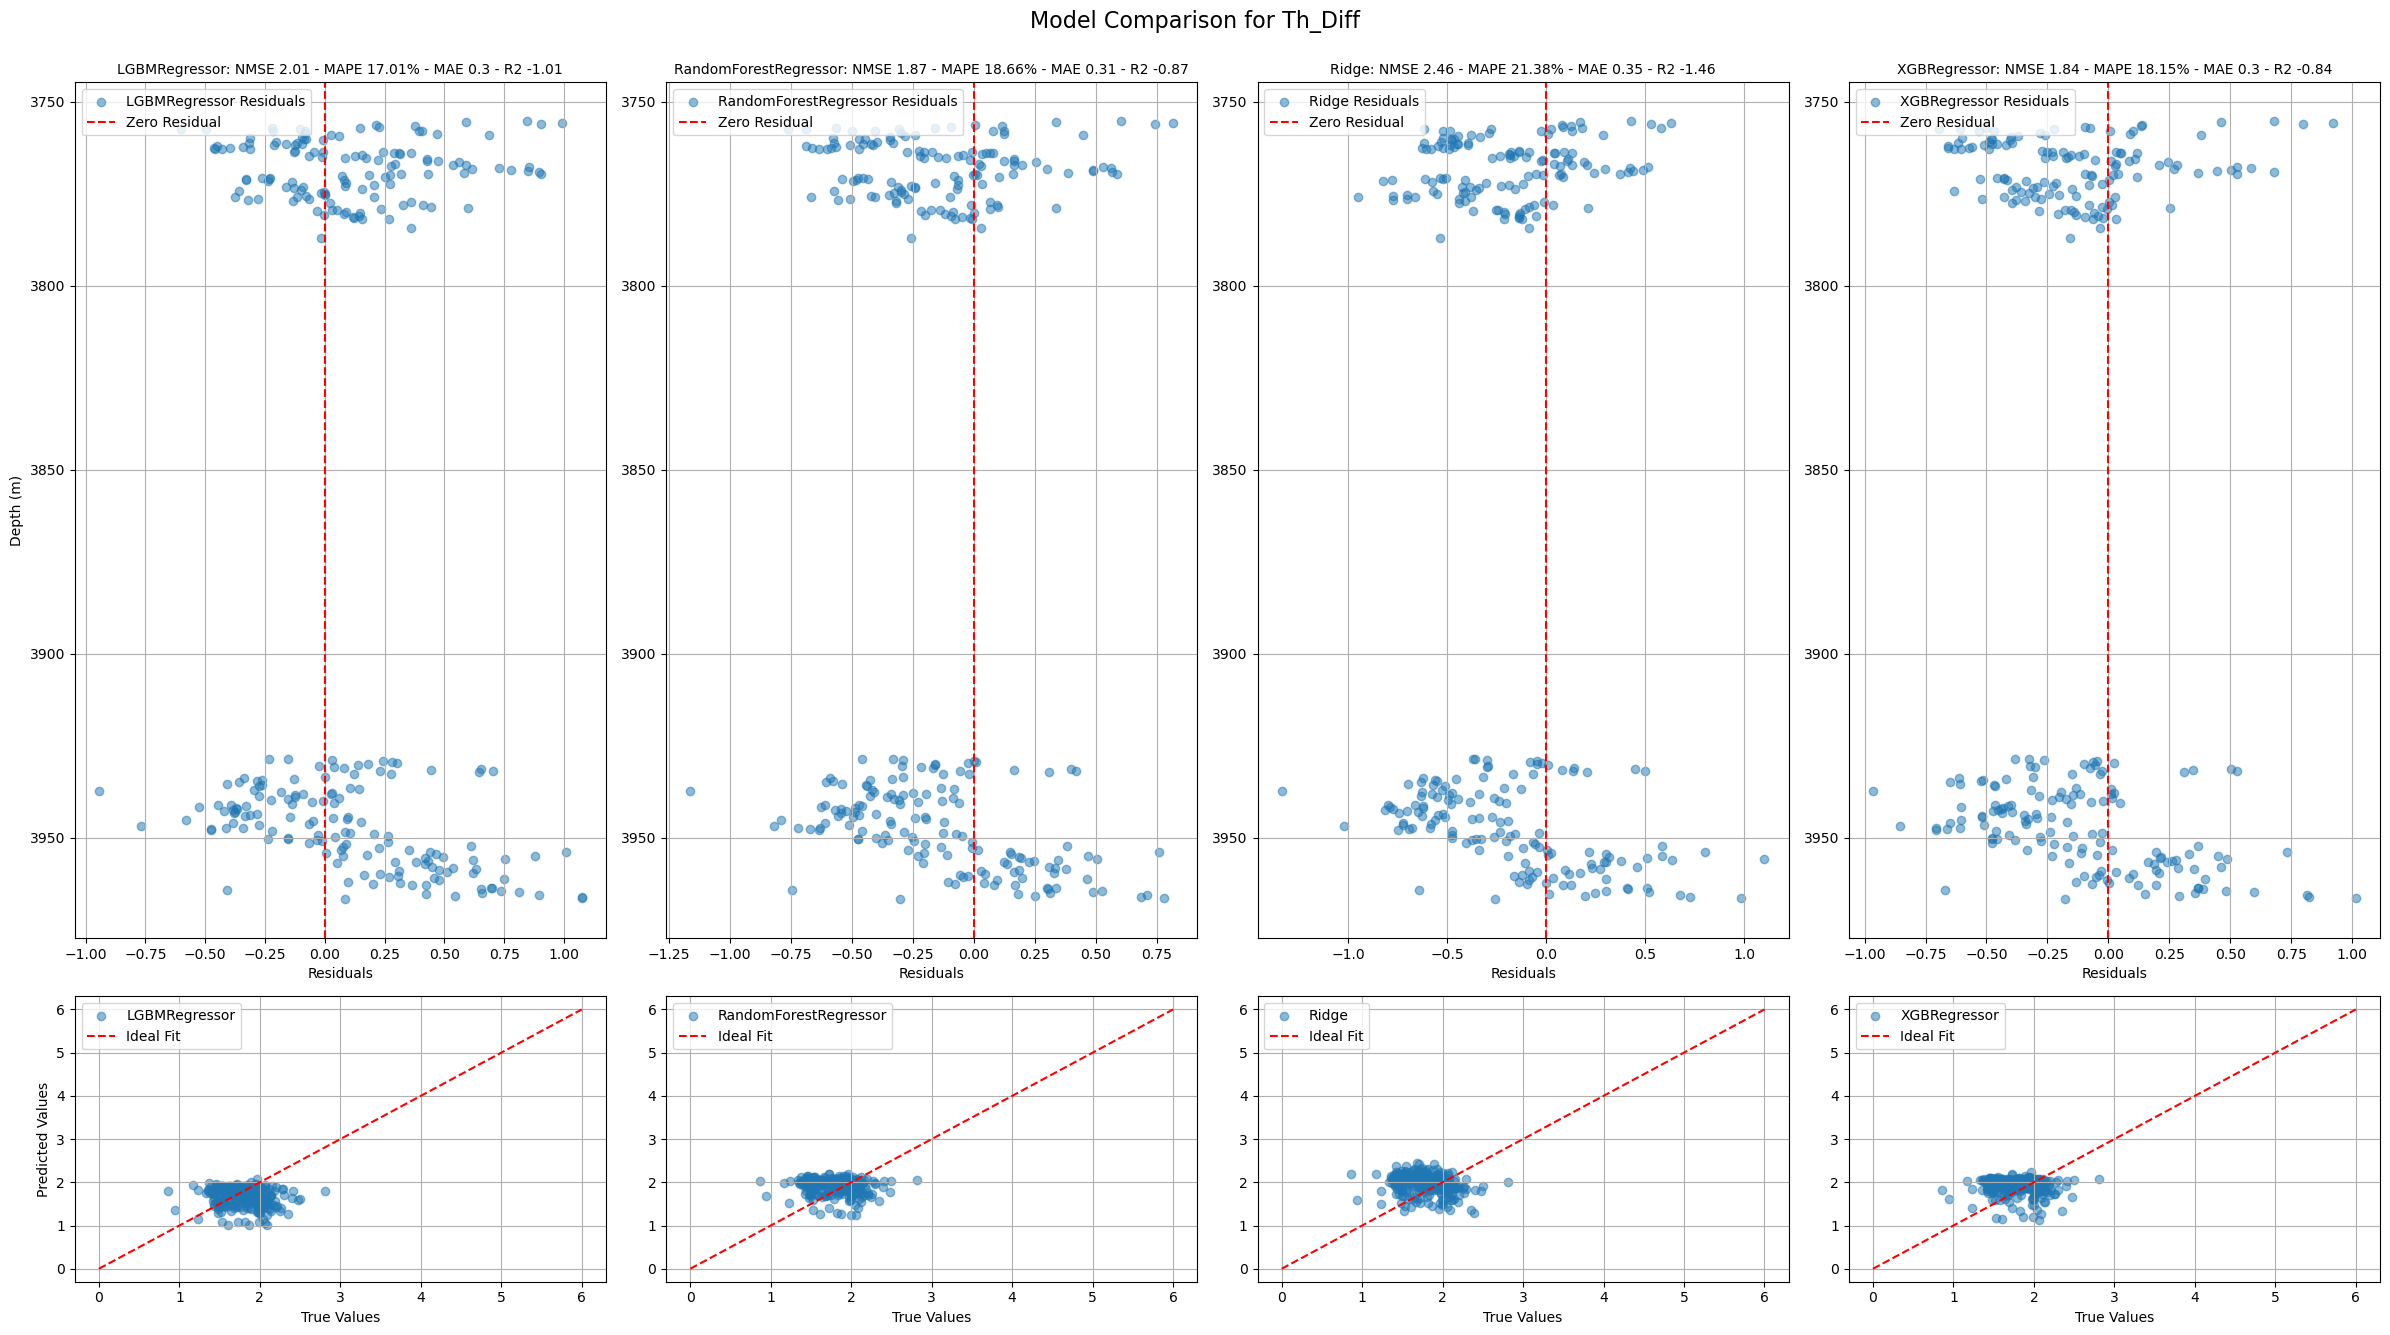

Well: K18-08


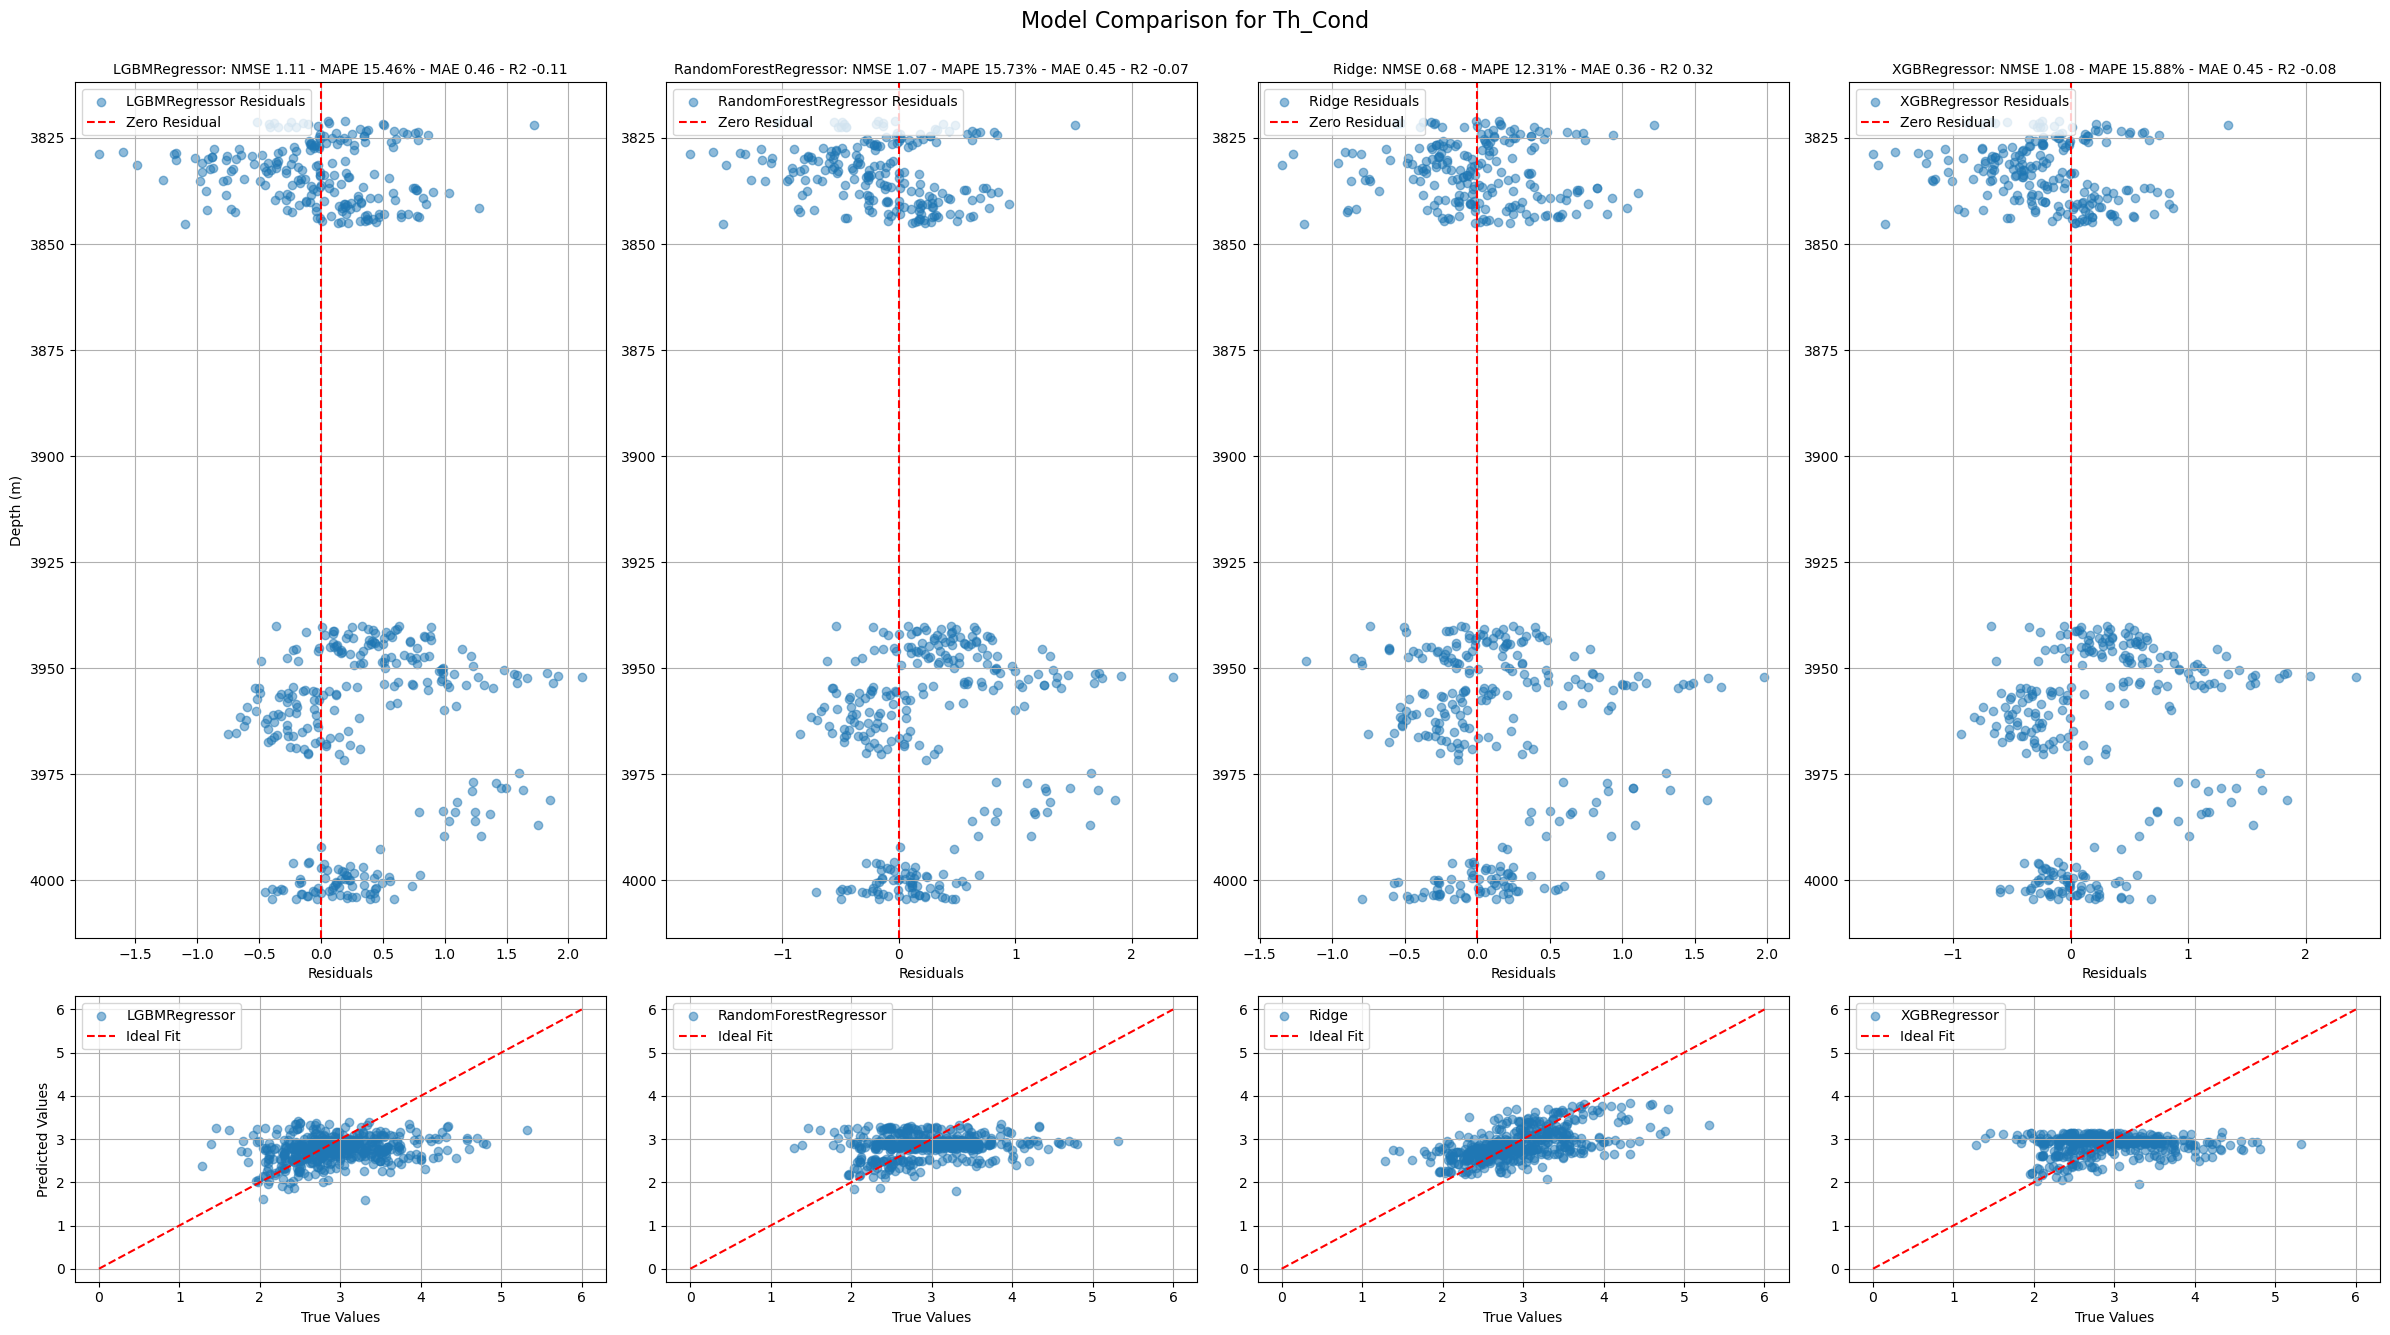

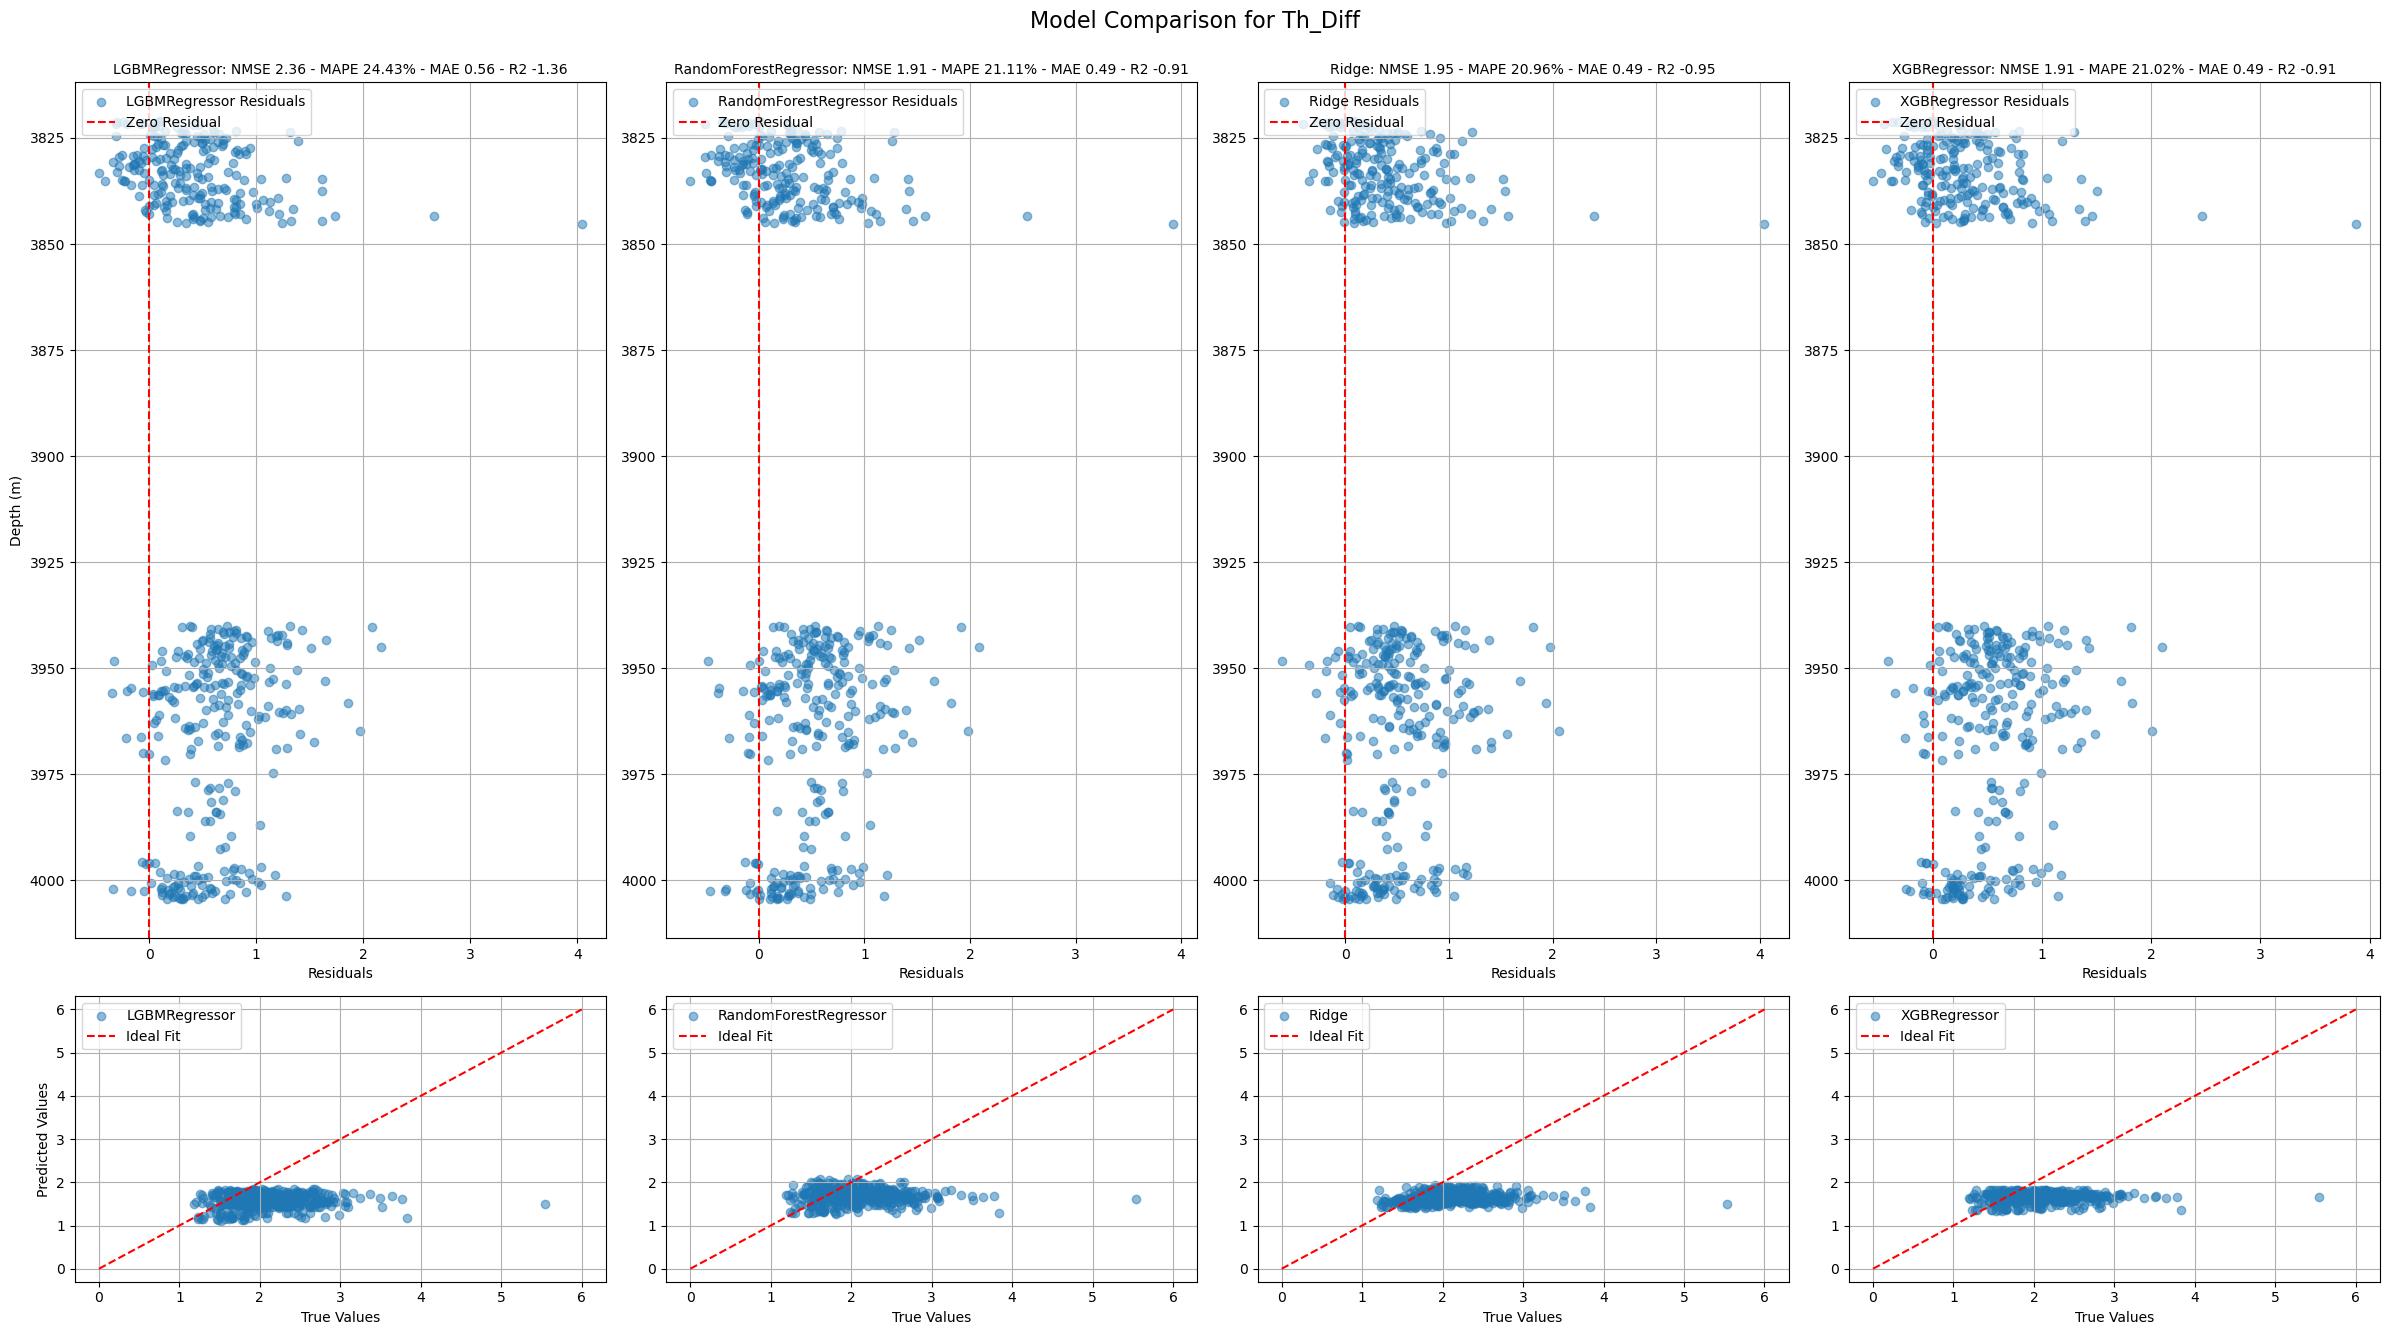

Well: ZRP-03a


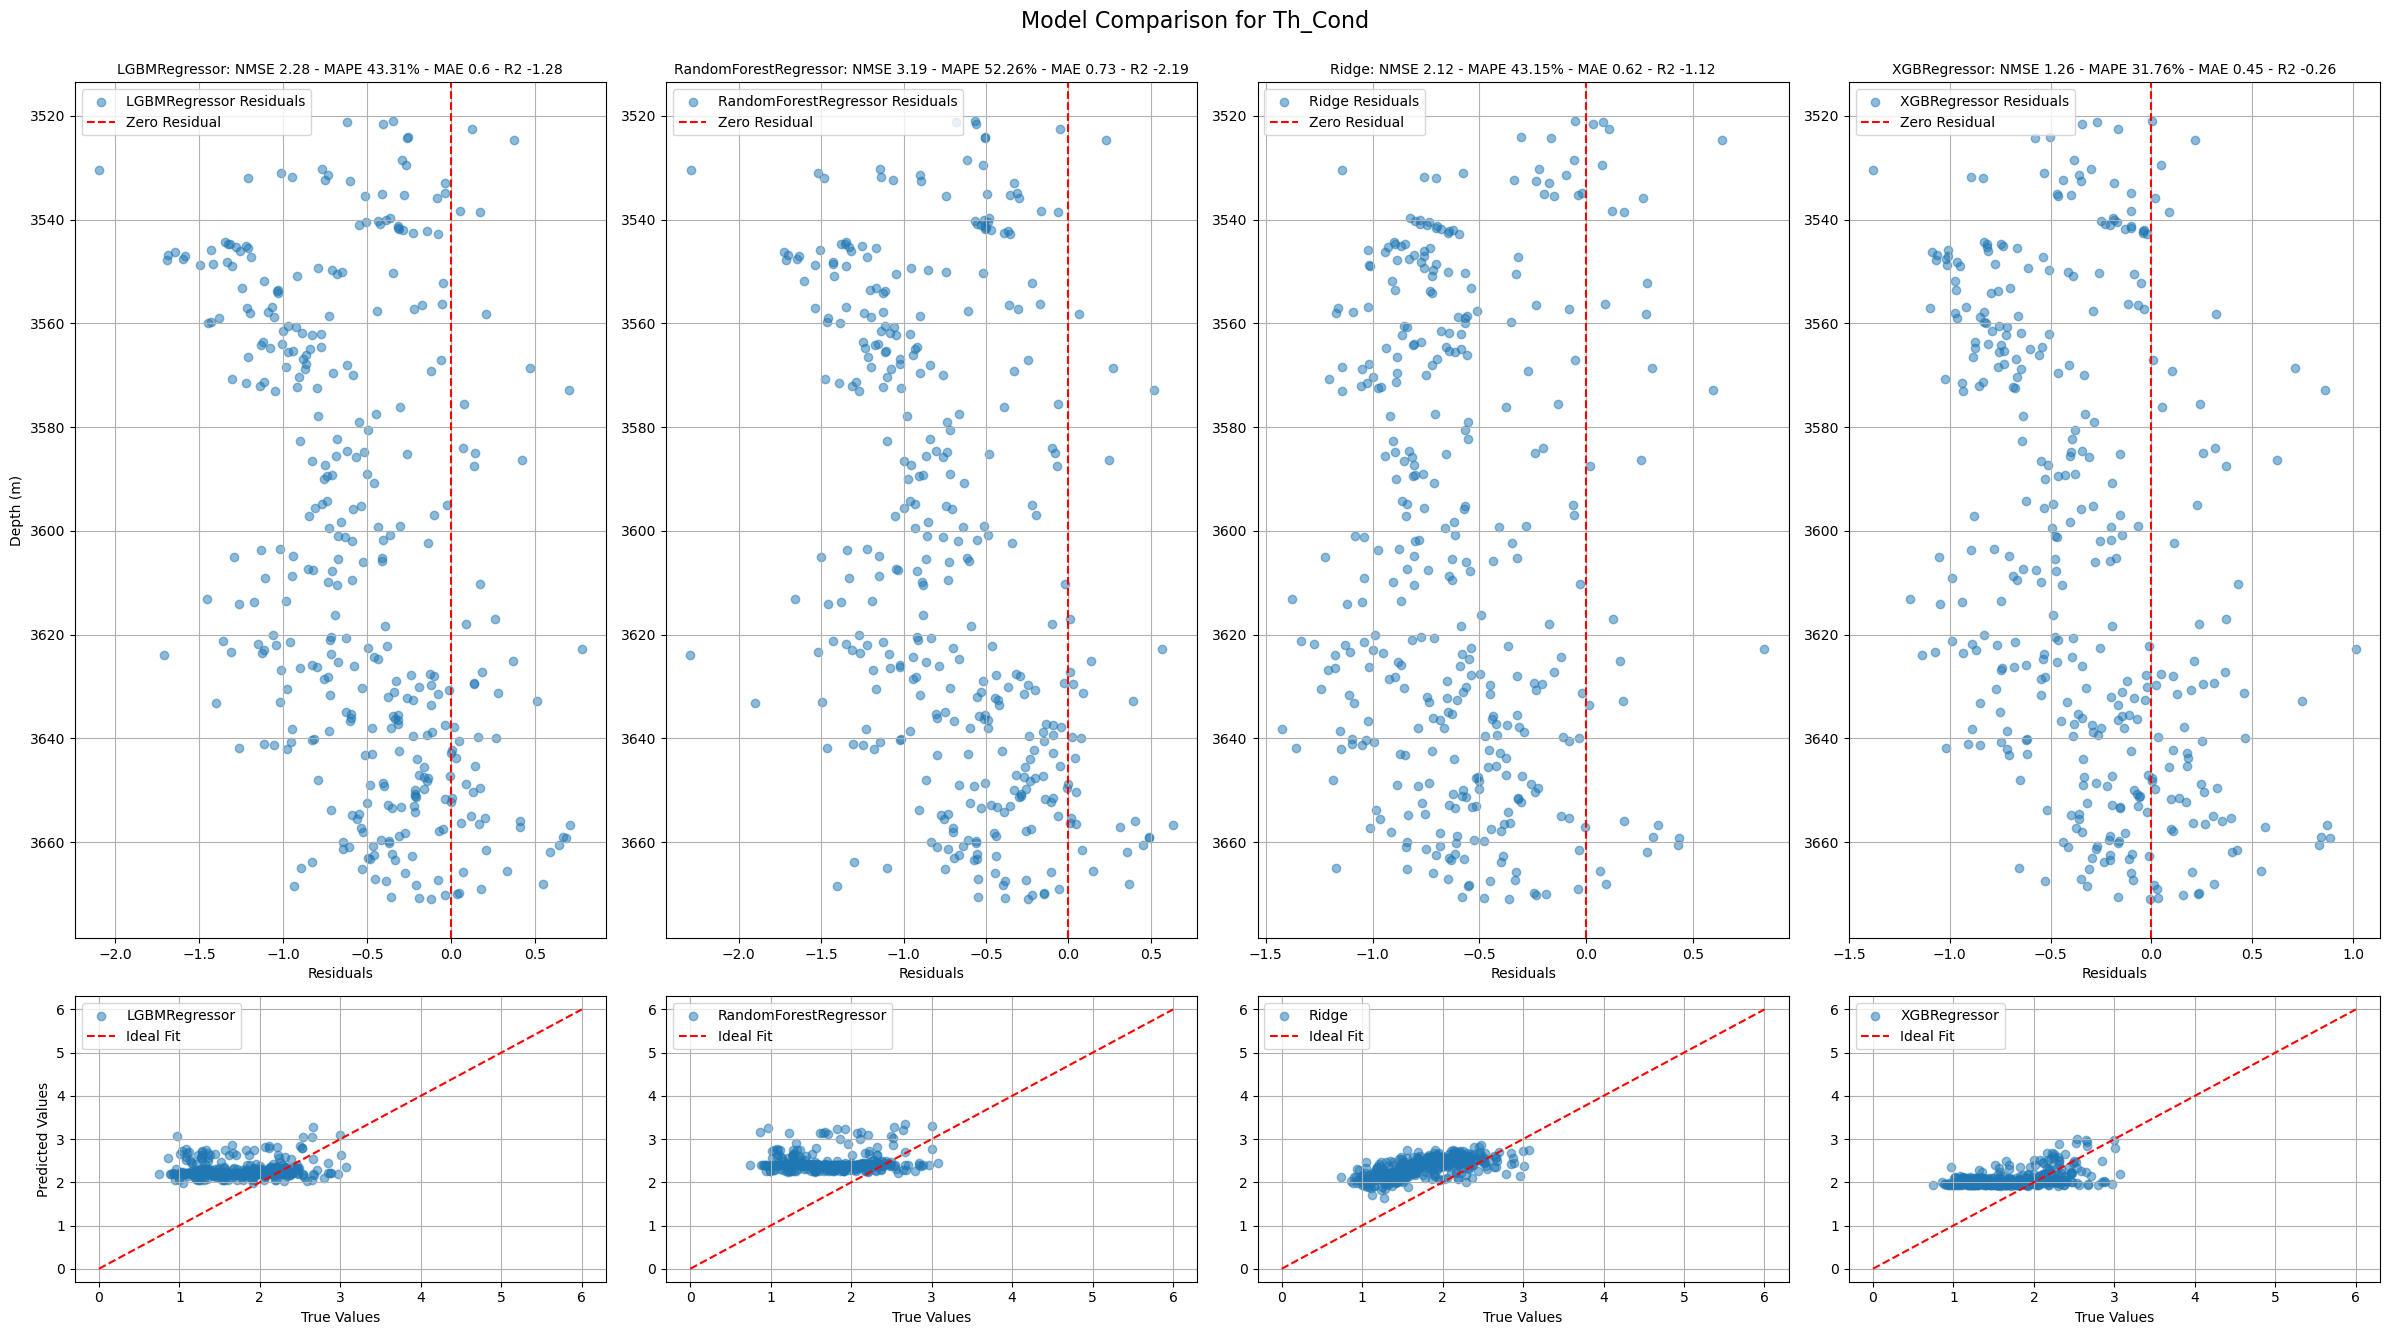

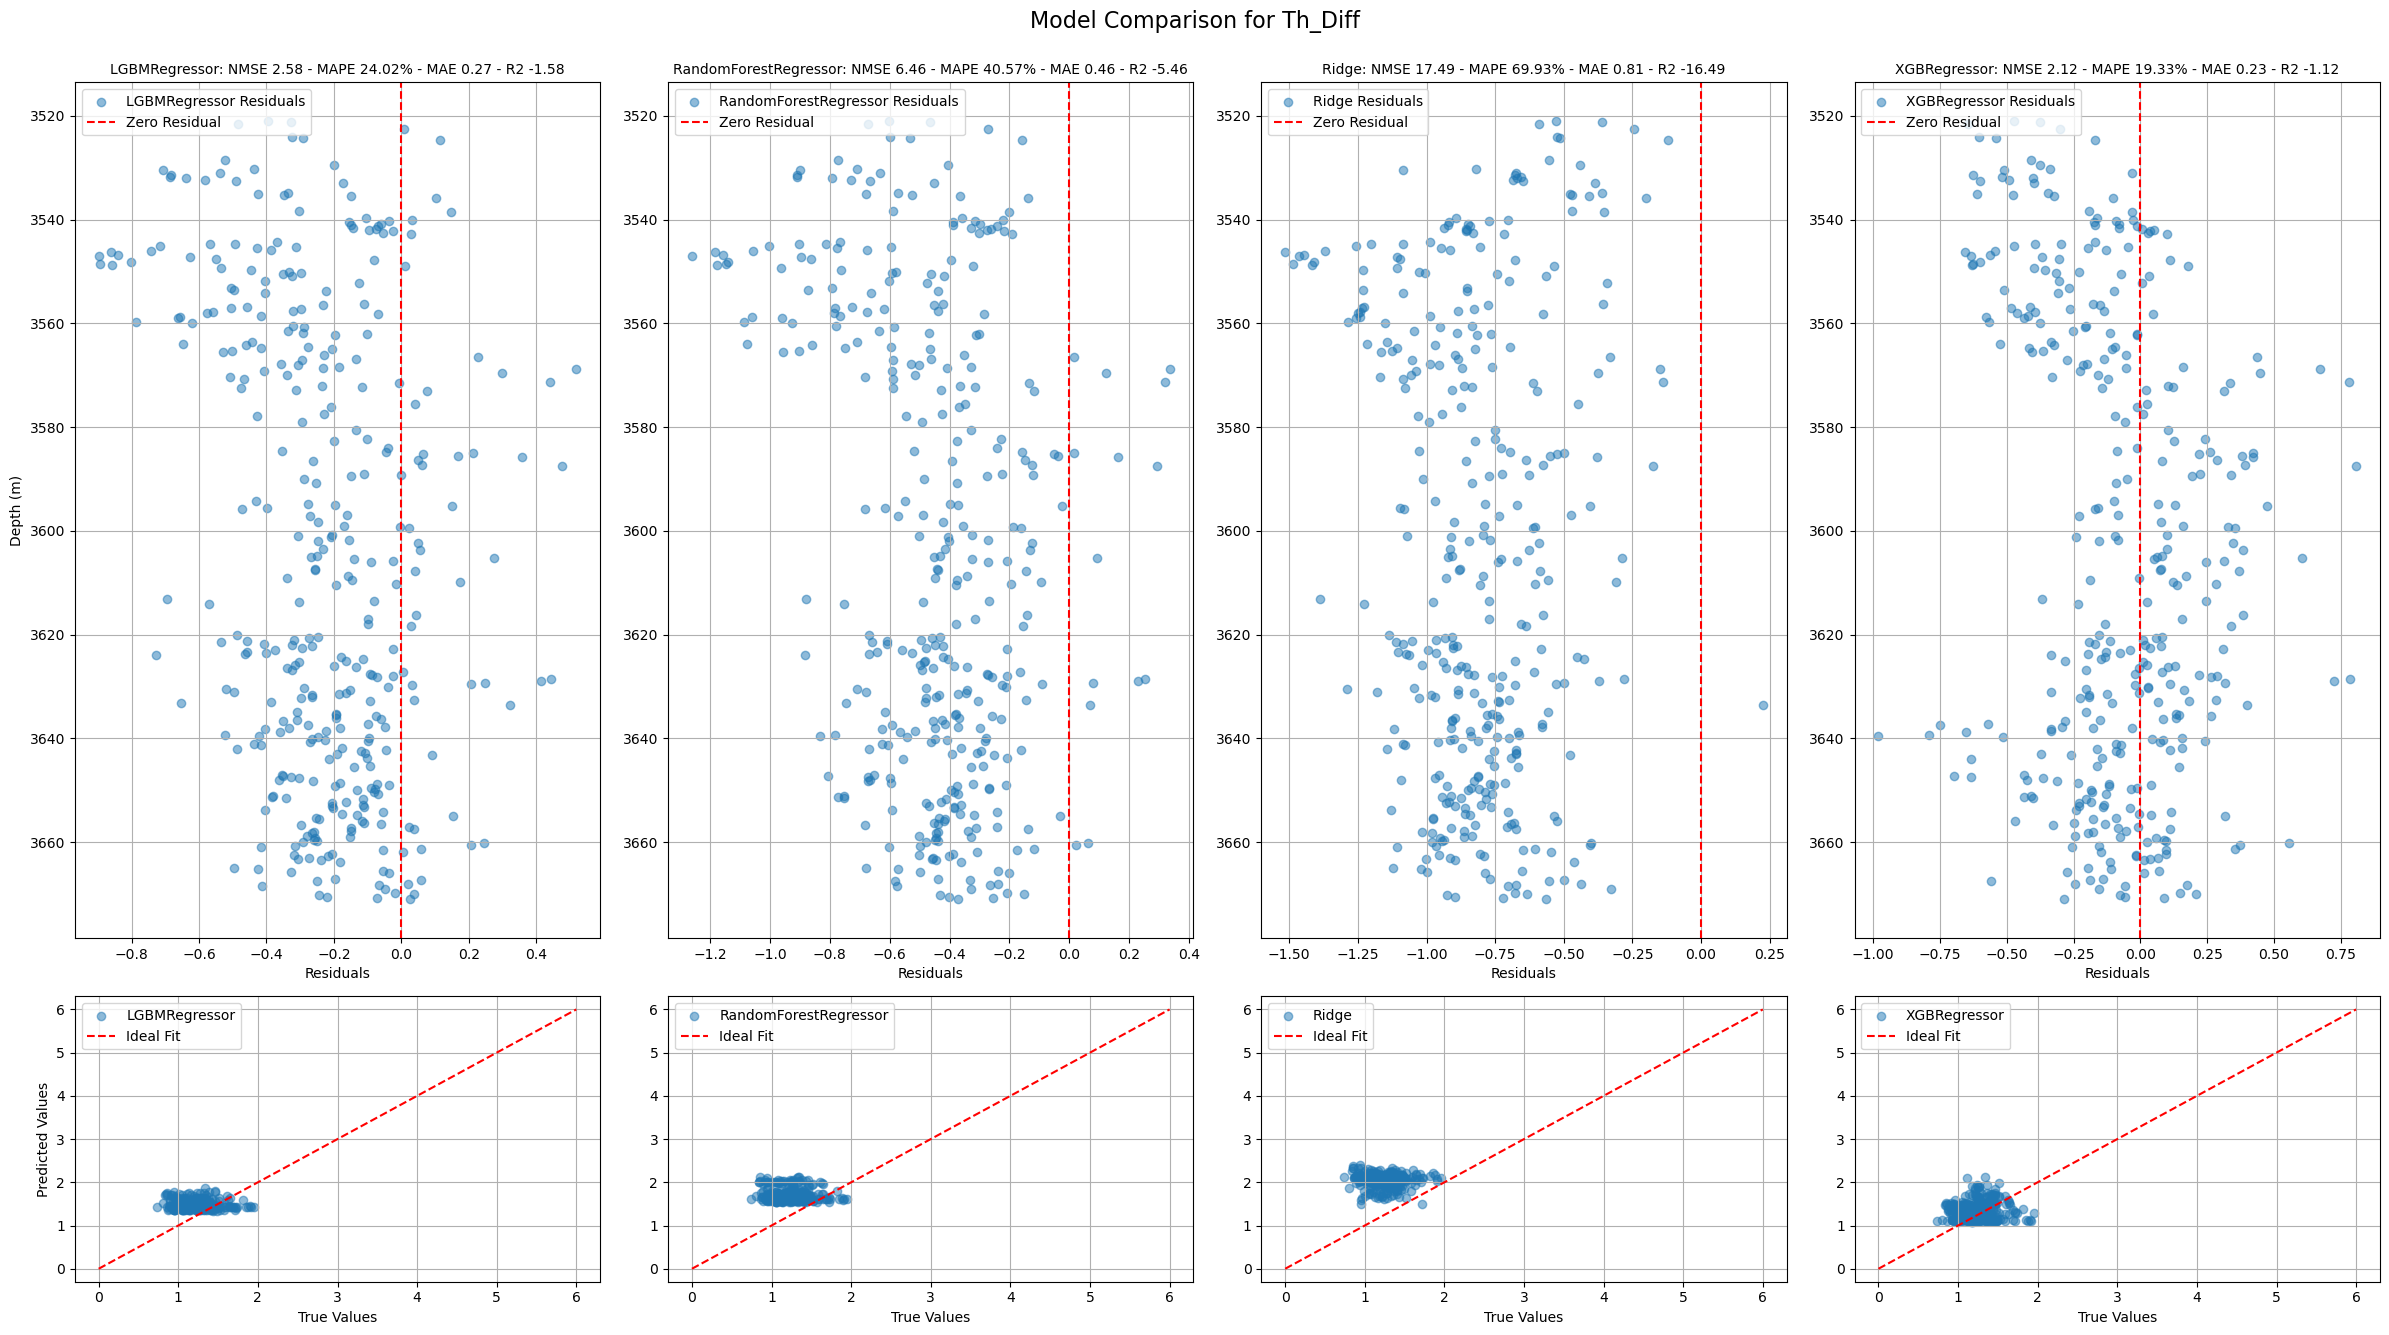

In [3]:
# Plot predictions for each well
for well in results_df['Well_ID'].unique():
    print(f'Well: {well}')
    framework.plot_model_comparison(results_df[results_df['Well_ID'] == well])

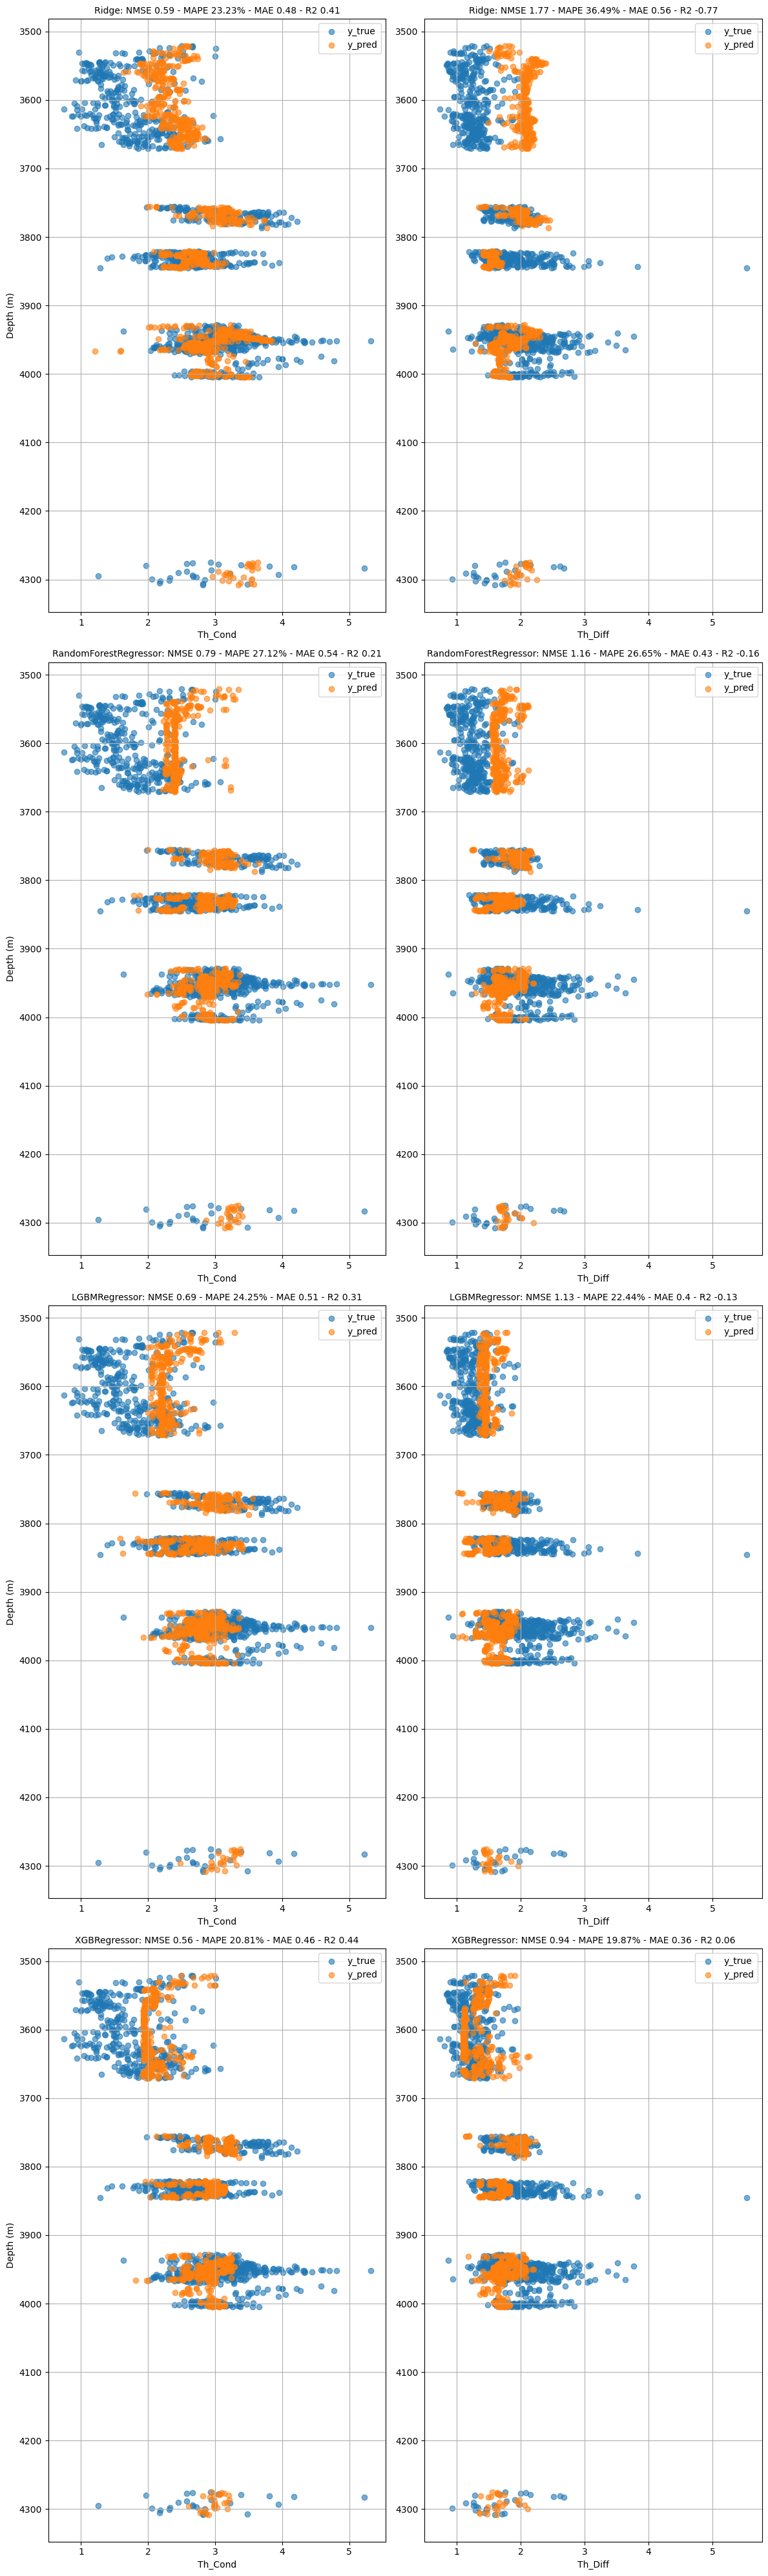

In [4]:
# Plot results
framework.plot_results_predictions(
    predictions_df=results_df,
    targets=TARGET_COLUMNS,  
    models=list(models_with_params.keys()),
    figsize=(15, 10), 
    alpha=0.6
)

Well: E18-05


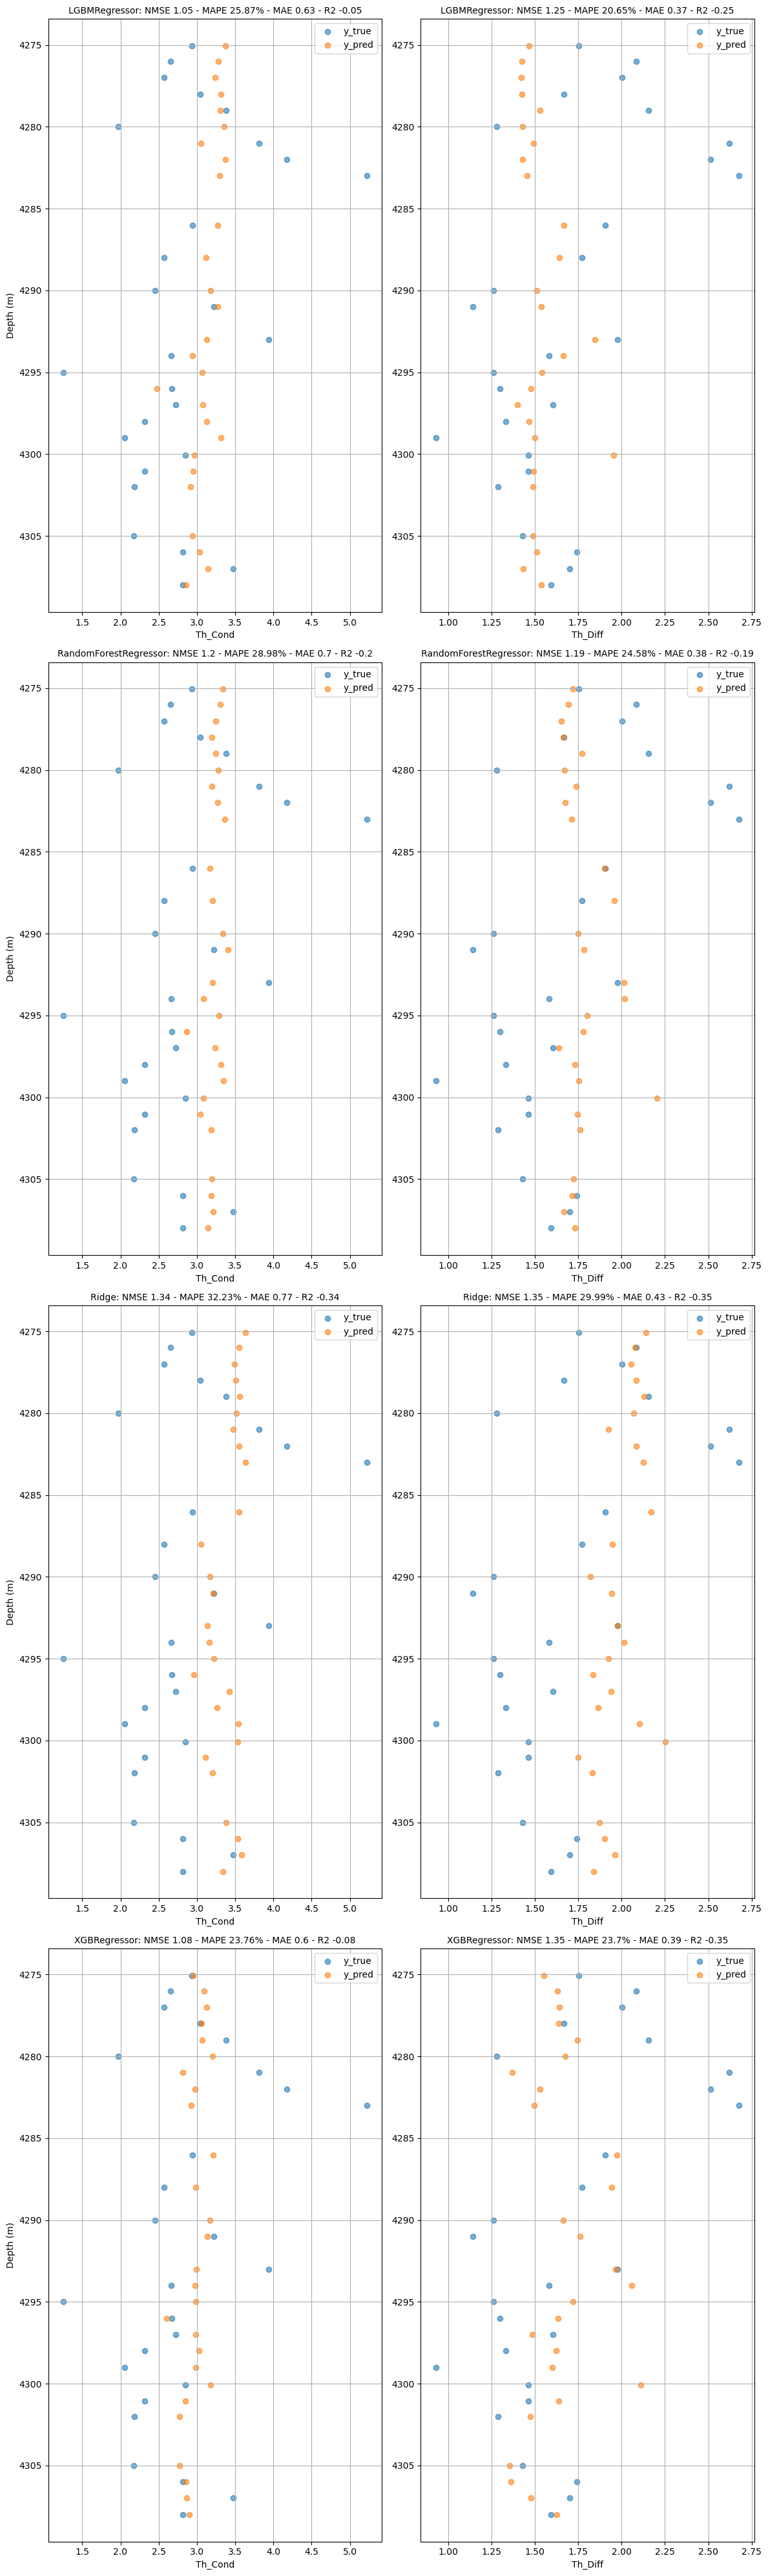

Well: K18-07x


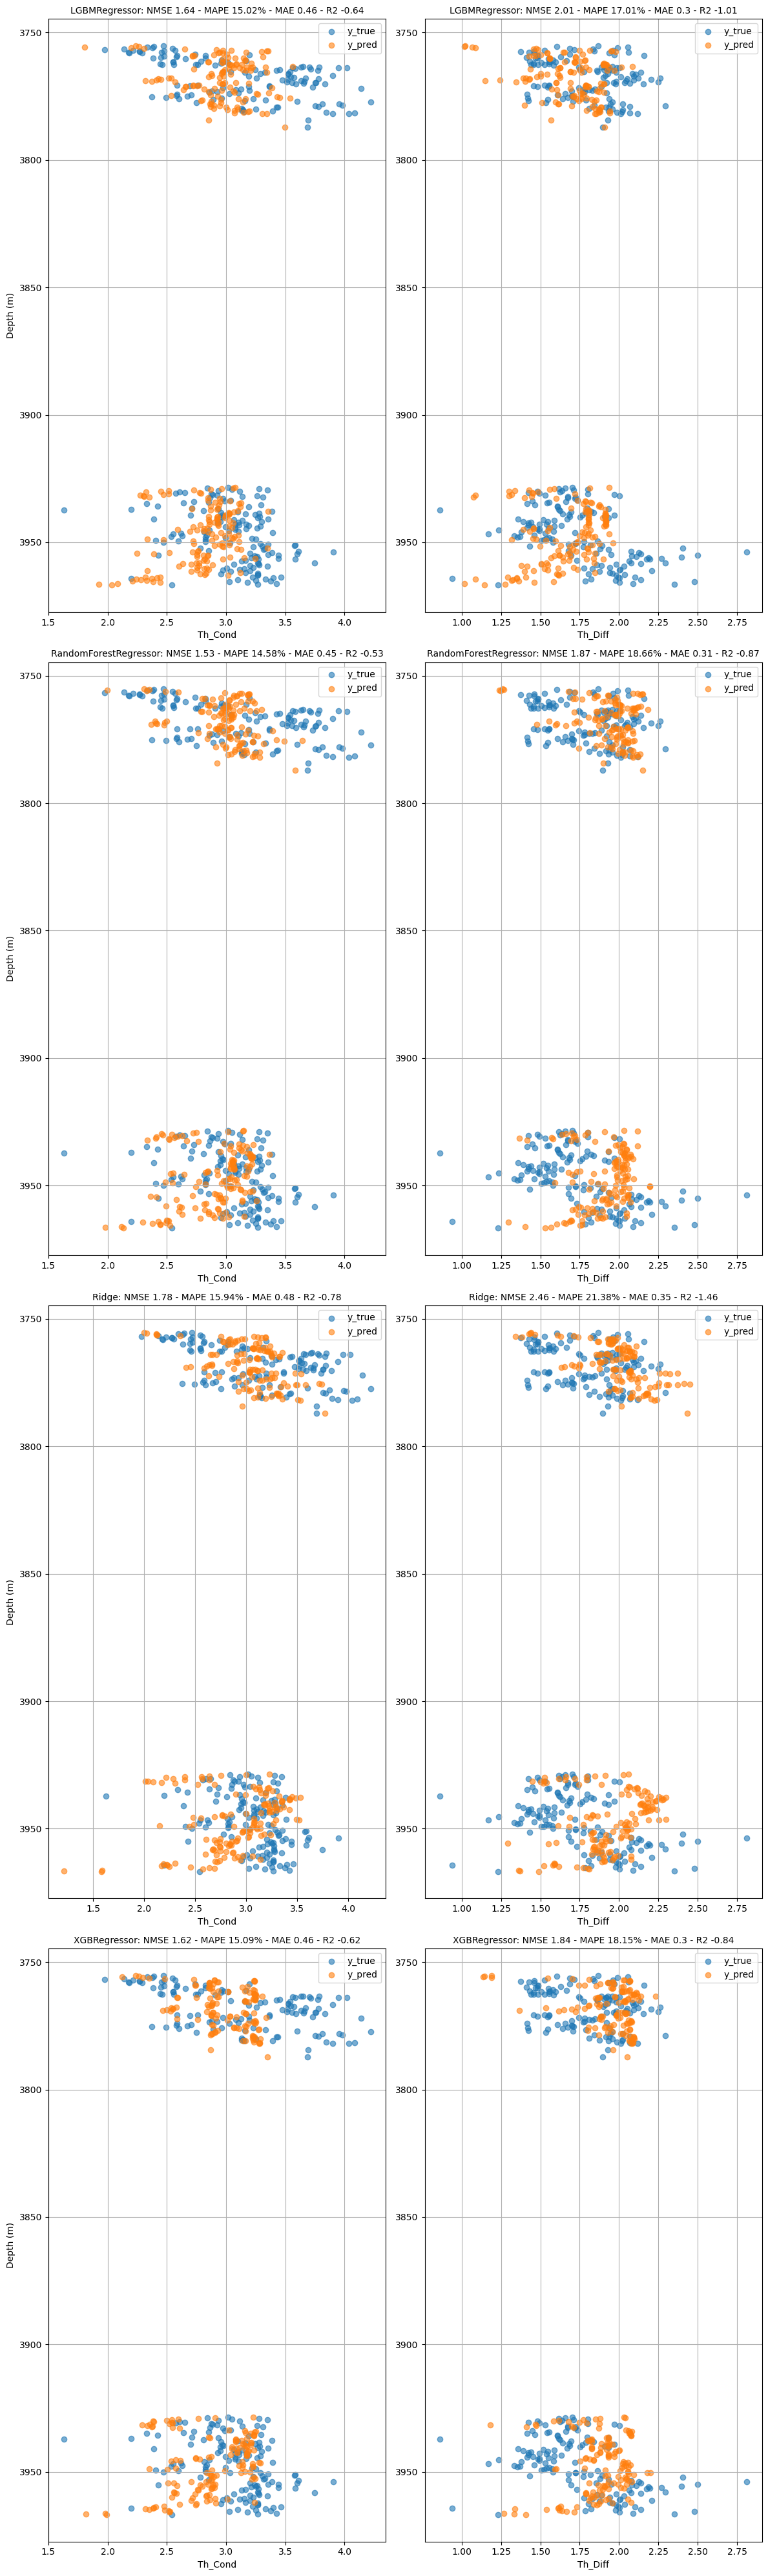

Well: K18-08


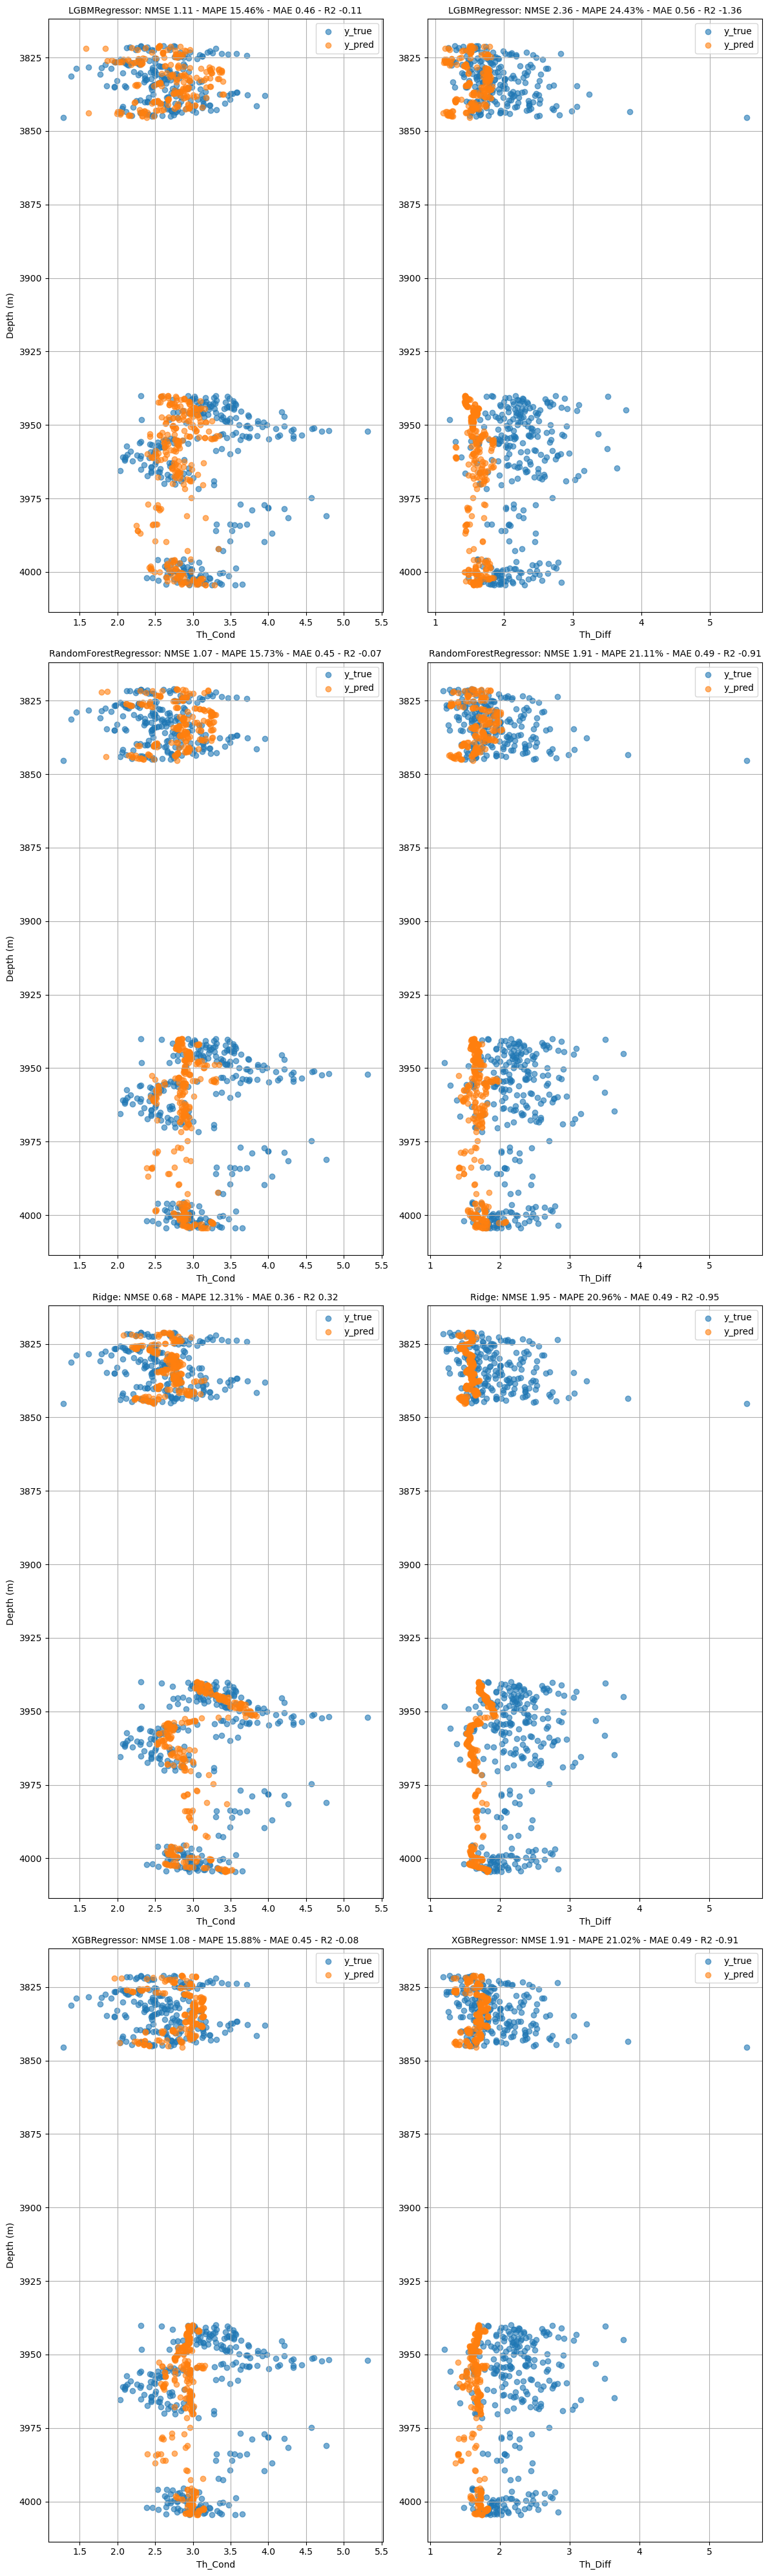

Well: ZRP-03a


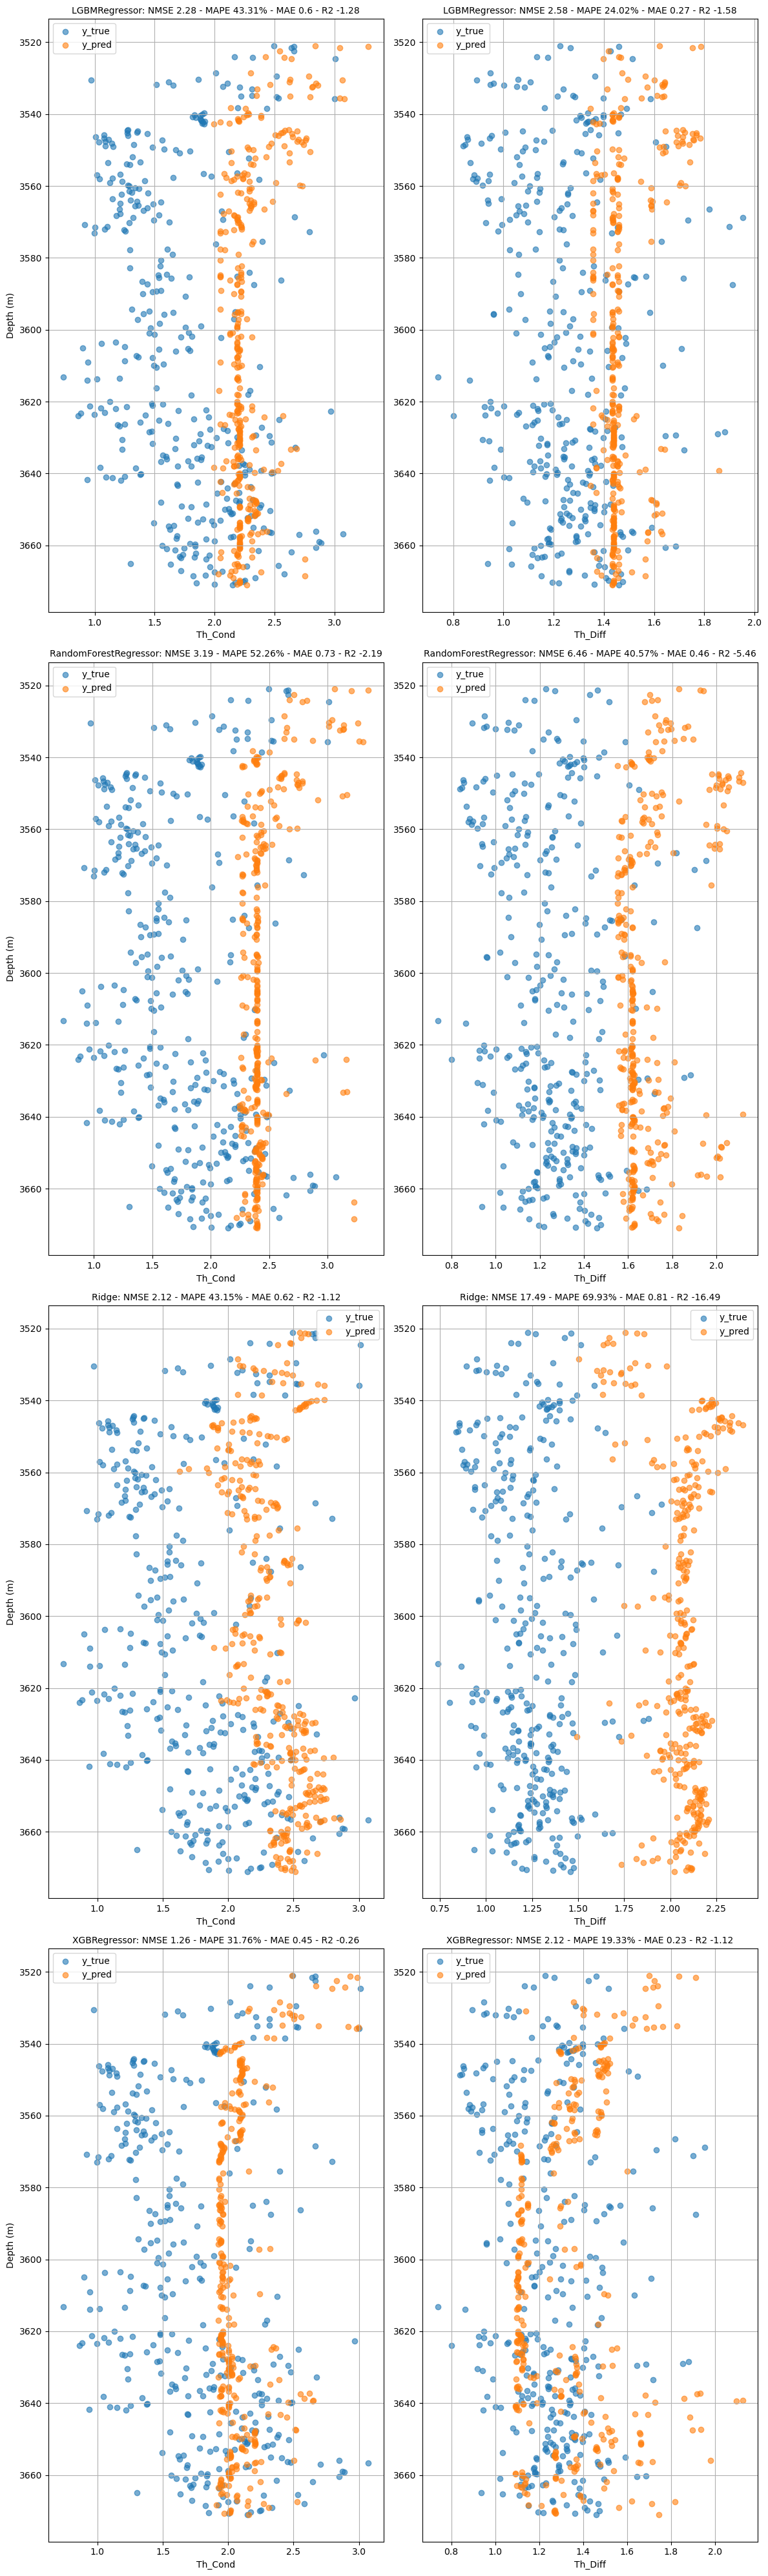

In [5]:
# Plot predictions for each well
for well in results_df['Well_ID'].unique():
    print(f'Well: {well}')
    framework.plot_results_predictions(results_df[results_df['Well_ID'] == well])


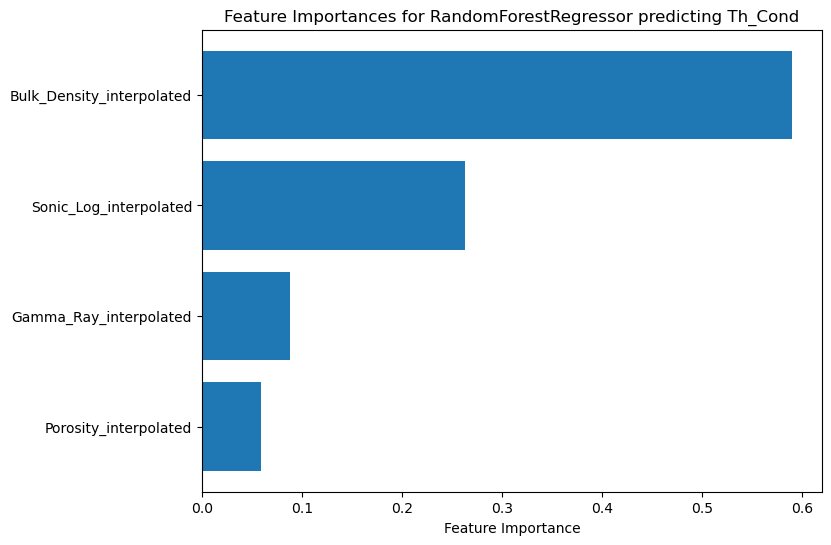

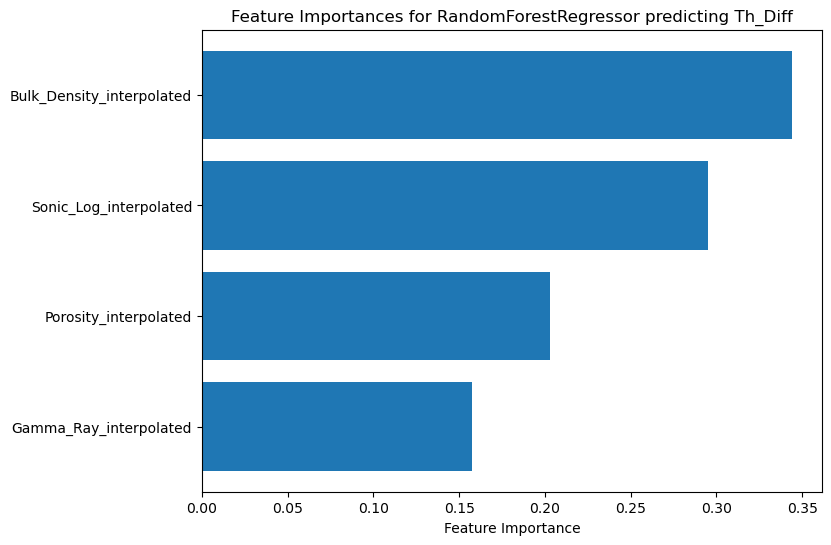

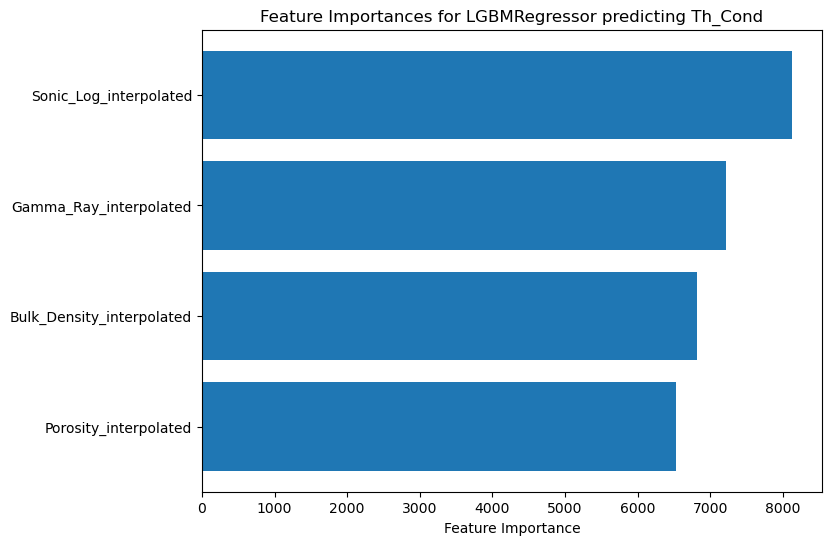

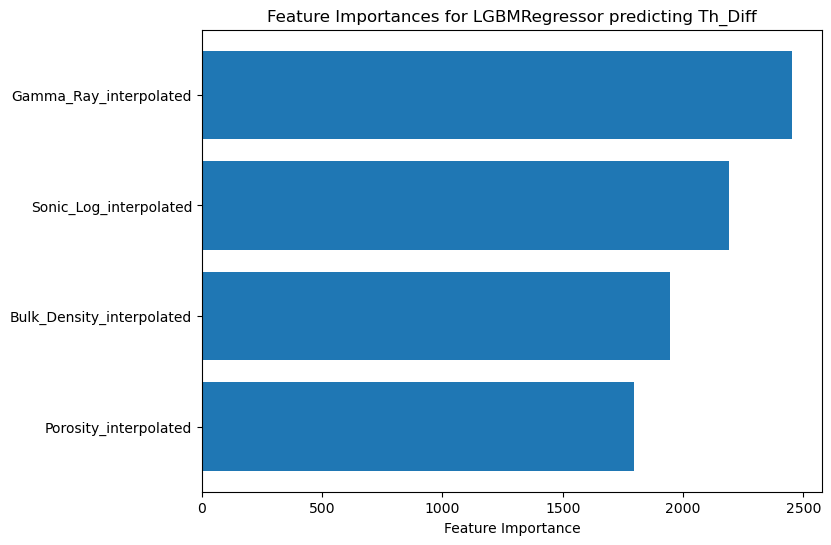

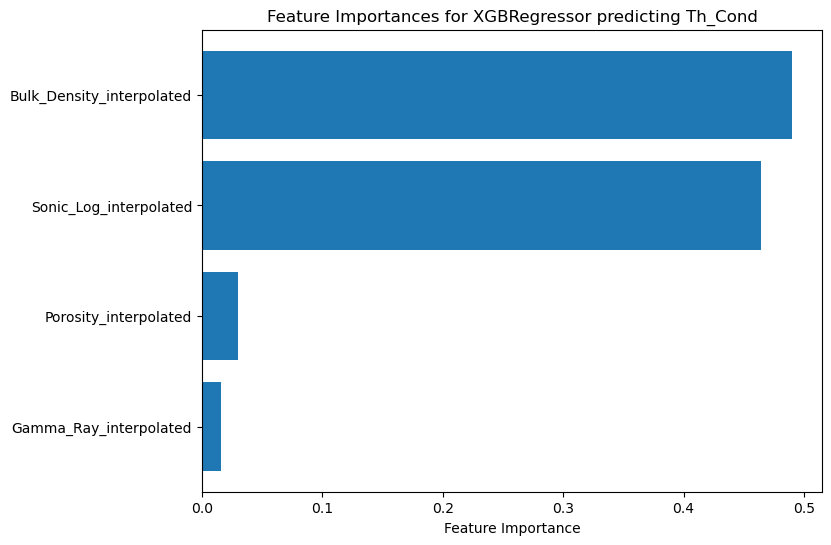

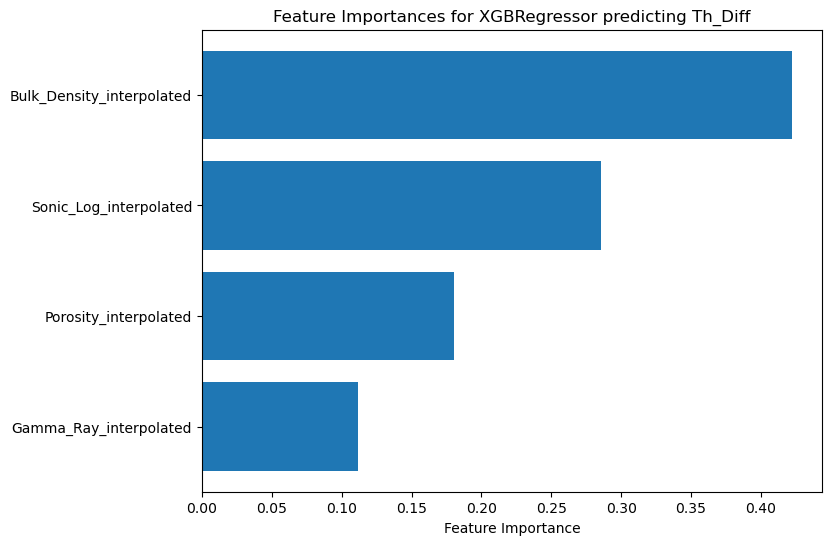

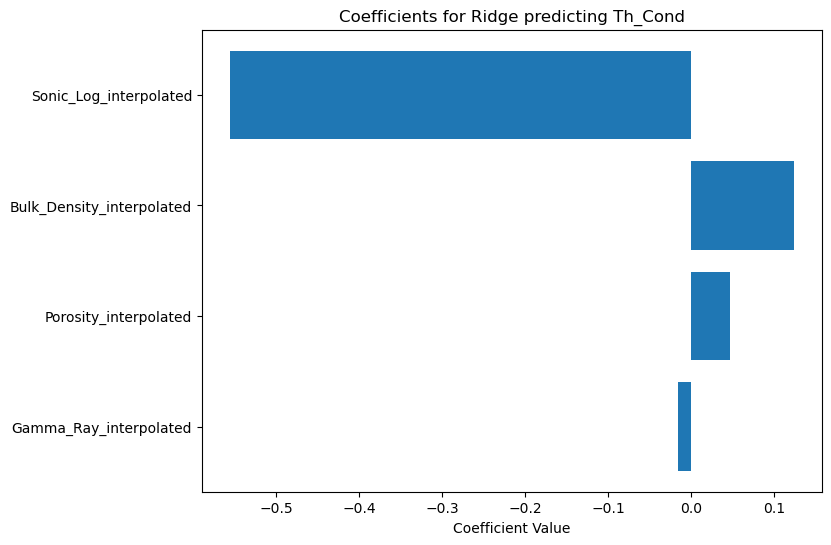

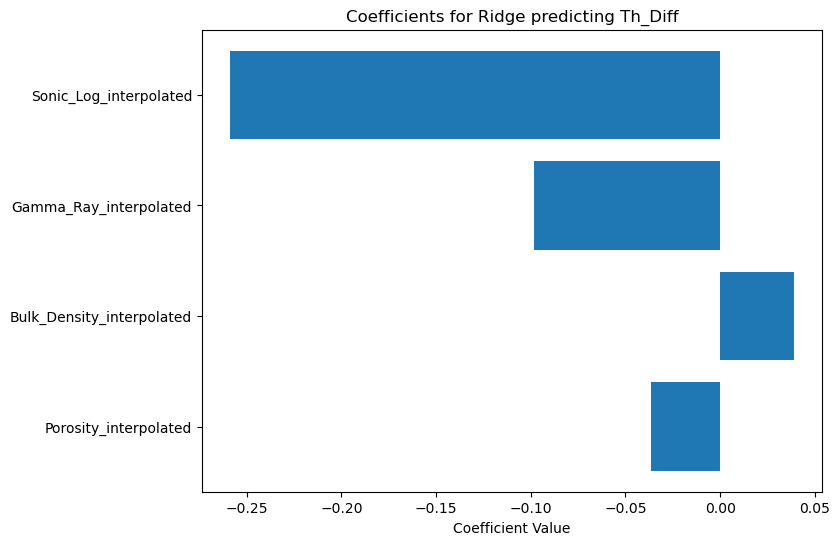

In [6]:
framework.plot_feature_importance(final_models)
framework.plot_coefficients(final_models)